In [1]:
import pandas as pd
import numpy as np
import os
import string
import datetime
from datetime import timezone
os.getcwd()
import glob
import pytz
import seaborn as sns
import re

In [2]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [3]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [4]:
def extract_vatican(source,place,country):
    #all pictures originate from a Pictures folder, remove the full path
    vatican_strings =['Apostolisch',"Vatikan","Petersdom","Santa Maria Maggiore","Lateran","Paolo fuori le Mura",
                     'Scala Scanta','Triclinium Leoninum','Petersplatz','Campo Santo Teutonico',"Sant' Anna",
                     'Sancta Sanctorum','Palazzo Pontifico','Villa Barberini']
    #including Pictures
    if place=="Rom" or place=="Castel Gandolfo":
        for v in vatican_strings:
            if v in source:
                country='Vatican'
    return country

In [5]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [6]:
def extractCityV2(filename):
    m = re.search(r'(?<=\s-\s)\D+?(,)', filename)
    if m==None:
        print("error in",filename)
    else:
        #print("test",m[0][:-1])
        return m[0][:-1]

In [7]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [8]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [9]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [10]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            #date_orig = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date = value
            if modelname=="SP500UZ":
                if(date>data_min and date<data_max):
                #never changed timezone after getting back from NYC, all messed up
                    date=date+datetime.timedelta(hours=6)
            return date
    except AttributeError:
        return np.NaN

In [11]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date = value
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                hour_bias=0
                data_max_olympus=datetime.datetime.now()
                date_max_olympus=datetime.date(2008,9,1)
                if(date.date()<date_max_olympus):
                    hour_bias=24
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:  
                    date=date-datetime.timedelta(hours=1)+datetime.timedelta(hours=hour_bias)
                    return date
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date=date-datetime.timedelta(hours=6)+datetime.timedelta(hours=hour_bias)
                    return date
                elif " Chicago - Edit2012/P" in filename:
                    date=date-datetime.timedelta(hours=7)+datetime.timedelta(hours=hour_bias)
                    return date    
                else:
                    value_new=date+datetime.timedelta(hours=hour_bias)
                    return value_new
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date=date+datetime.timedelta(hours=1) 
                    return date
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=9)
                    return date
                elif "- Chicago, " in filename:
                    date=date-datetime.timedelta(hours=7)
                    return date
                elif " - Washington D.C., " in filename:
                    date=date-datetime.timedelta(hours=6)
                    return date
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif "161205 - Japan/" in filename:
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #change to default summer time
                    return date
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D): 
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif "150613 - Los Angeles/" in filename:
                    date=date-datetime.timedelta(hours=10)
                    return date
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date=date+datetime.timedelta(hours=6)
                        return date
                    else:
                        #change to default summer time
                        date=date-datetime.timedelta(hours=1)
                        return date
                else:
                    #change to default summer time
                    date=date-datetime.timedelta(hours=1)
                    return date
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=6)
                    return date
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif " - Groenland" in filename:
                    date=date-datetime.timedelta(hours=4)
                    return date
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "/170609 USA/" in filename:
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=2)
                    return date
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=3)
                    return date
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #always on summer time
                    return date
    except AttributeError:
        return np.NaN

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

datamax=datetime.datetime.now()
datamin=datetime.datetime.now()


"""    
columns_to_keep=['SourceFile','Aperture','AspectRatio','AutoISO','BaseISO','BitsPerSample',
                'ColorSpace','ColorTemperature','Contrast','DateTimeOriginal','DateTimeOriginal'
                    'ExposureTime','FileName','Flash','FocalLength','FocalLength35efl','ImageSize',
                    'ImageWidth','ISO','Lens','Lens35efl','LightValue','MaxAperture','MinAperture','MinFocalLength',
                     'Model','Orientation','PictureStyle','Quality','RedBalance','ShutterSpeed',
                    'TargetAperture','TimeZone','TimeZoneCity','WB_RGGBLevels','WB_RGGBLevelsAsShot',
                    'WBBracketMode','WhiteBalance','WhiteBalanceBlue','WhiteBalanceRed','BlueBalance']
"""

for input in range(2006,2022):
    #print("get to year",input)
    file_name=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
    df_test=df_test.dropna(subset=['BitsPerSample'])
#for c in df_test.columns:
#    print("col",c,df_test[c].isna().sum(),df_test.shape)

    columns_to_keep=['SourceFile','Aperture','ApertureValue','BitsPerSample','BlueBalance','ColorSpace','ColorTempAsShot','Contrast',
                 'DateTimeOriginal','ExposureTime','FileName','Flash','FlashActivity','FNumber','FocalLength','CreateDate',
                 'FocalLength35efl','ImageSize','ImageWidth','ISO','LightValue','Model','Orientation',
                 'Quality','ShutterSpeed','ShutterSpeedValue','WB_RGGBLevelsAsShot','WhiteBalance']
    #df_test=df_test[columns_to_keep]
    df_test=df_test[df_test.columns.intersection(columns_to_keep)]
    df_test["Place"]=df_test.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_test['SourceFile']=df_test['SourceFile'].apply(remove_full_path)    
    df_test['FocalLength']=df_test['FocalLength'].apply(convert_mm) 
    df_test['ExposureTime']=df_test['ExposureTime'].apply(convert_exposure)
    df_test=df_test.replace({'DateTimeOriginal': {'0000:00:00 00:00:00': '2006:01:10 15:20:30'}})
    df_test['DateTimeOriginal']=pd.to_datetime(df_test['DateTimeOriginal'],format='%Y:%m:%d %H:%M:%S')
    df_test['year']=int(input)
    df_test['dayperiod']=df_test.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df_test['CompositePhoto']=df_test.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df_test['Movie']=df_test.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df_test.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df_test['Date']=df_test.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    #total_rows=df_test['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df_test.loc[df_test['SourceFile'].str.contains("P7080022 - New York City")]
            datamin=df_test.at[test.index.values.astype(int)[0],"Date"]   
            print("correction should begin somewhere here 2009",test,"index is",test.index.values.astype(int)[0],datamin)
            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df_test.loc[df_test['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            print("correction should end somewhere here 2010",test,"index is",test.index.values.astype(int)[0],datamax)
            datamax=df_test.at[test.index.values.astype(int)[0],"Date"] 

            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    dataframe_list.append(df_test)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

combine_all_data=pd.DataFrame(dataframe_list[0]) 
dataframe_list.pop(0)
for data in dataframe_list:
        #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2021.csv")
combine_all_data


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,4,6,7,8,9,12,13,14,15,21,22,24,34,40,42,44,45,46,48,49,51,71,79,81,82,83,84,86,87,94,104,110,111,112,115,122,130,136,140,142,143,145,149,150,151,152,158,160,162,163,164,165,166,167,169,177,195,204,205,206,209,212,213,216,218,219,220,223,226,239,240,241,242,245,246,247,250,256,257,262,265,288,290,295,300,301,308,310,319,321,322,325,326,327,328,332,335,336,337,338,339,340,345,347,349,353,354,355,357,364,365,366,367,368,369,370,371,372,373,374,375,376,394,395) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,6,7,10,11,14,15,19,21,23,24,29,30,34,36,38,39,40,42,43,45,46,48,49,51,53,54,58,59,60,61,63,66,67,70,71,72,73,76,77,78,79,80,81,82,85,86,87,88,89,90,91,107,114,116,125,127,129,130,131,

correction should begin somewhere here 2009                                              SourceFile  Aperture  \
3277  /2009/090623 USA CTEQ09/090703 New York City/P...       3.0   

      ApertureValue  BitsPerSample ColorSpace Contrast           CreateDate  \
3277            NaN            8.0       sRGB   Normal  2009:07:08 19:48:04   

                    Date  ExposureTime  \
3277 2009-07-08 13:48:04        0.0125   

                                               FileName  ...  \
3277  P7080022 - New York City, Lufthansa Boeing 747...  ...   

              Orientation      Quality  ShutterSpeed ShutterSpeedValue  \
3277  Horizontal (normal)  HQ (Normal)          1/80               NaN   

     WhiteBalance          Place  year  dayperiod CompositePhoto Movie  
3277         Auto  New York City  2009          1              0     0  

[1 rows x 29 columns] index is 3277 2009-07-08 13:48:04


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,4,5,6,7,8,11,13,21,23,25,26,39,40,41,43,45,46,47,49,50,52,54,55,73,74,76,78,79,80,90,93,97,99,109,115,117,118,119,120,137,145,147,149,150,152,155,156,160,162,164,166,167,168,169,170,171,172,173,180,185,186,187,188,190,196,213,214,216,218,224,225,226,228,229,232,247,250,253,261,262,264,272,278,279,280,286,291,308,310,313,315,316,317,318,321,322,323,345,346,372,373,374,376,385,389,399,400,401,402,403,407,410,416,417,418,419,423,424,426,428) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


correction should end somewhere here 2010                                              SourceFile  Aperture  \
5389  /2010/100827 Jura/P8270068 - Le Locle, unterir...       2.8   

      ApertureValue  BitsPerSample ColorSpace Contrast           CreateDate  \
5389            NaN            8.0       sRGB   Normal  2010:08:27 16:15:55   

                    Date  ExposureTime  \
5389 2010-08-27 16:15:55           2.5   

                                            FileName  ...   Orientation  \
5389  P8270068 - Le Locle, unterirdische Muehlen.JPG  ...  Rotate 90 CW   

      Quality  ShutterSpeed ShutterSpeedValue WhiteBalance     Place  year  \
5389      NaN           2.5               NaN         Auto  Le Locle  2010   

      dayperiod CompositePhoto Movie  
5389          1              0     0  

[1 rows x 29 columns] index is 5389 2021-04-01 21:52:32.742782


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,5,6,7,9,15,16,17,19,29,32,37,38,39,41,42,44,45,54,56,61,63,64,68,74,75,76,78,80,82,83,84,92,98,100,101,102,111,114,122,136,138,139,140,142,149,151,153,156,157,158,159,160,165,167,170,171,172,173,174,180,184,189,192,195,202,208,209,212,213,214,215,219,221,222,223,226,227,228,231,239,242,256,257,260,261,264,266,273,278,279,280,281,283,284,285,287,288,290,293,307,312,323,325,332,333,344,345,348,350,355,359,360,361,362,367,370,374,375,381,387,389,390,391,400) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5,12,15,16,28,32,34,49,50,51,52,64,65,73,109,118,134,135,137,138,140,145,161,179,180,191,200,212,214,215,219,220,225,232,240,241,245,250,253,255,256,259,260,261,263,273,276,282,290,293,

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,year,dayperiod,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,2006,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,2006,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,2006,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,2006,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,2006,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103787,/2021/210401 Lauchringen/P4010005 - Lauchringe...,9.0,8.0,sRGB,Normal,2021:04:01 14:01:58,2021-04-01 14:01:58,0.003125,"P4010005 - Lauchringen, Baum.JPG","Off, Did not fire",...,2021,1,0,0,9.1,1.665039,5168.0,0.0,1/332,1786 1024 1024 1705
103788,/2021/210401 Lauchringen/P4010001 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 13:59:29,2021-04-01 13:59:29,0.008000,"P4010001 - Lauchringen, Baum.JPG","Off, Did not fire",...,2021,1,0,0,5.7,1.678711,5178.0,0.0,1/128,1808 1024 1024 1719
103789,/2021/210401 Lauchringen/P4010002 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:00:44,2021-04-01 14:00:44,0.005000,"P4010002 - Lauchringen, Baum.JPG","Off, Did not fire",...,2021,1,0,0,5.7,1.684570,5178.0,0.0,1/197,1814 1024 1024 1725
103790,/2021/210401 Lauchringen/P4010009 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:03:57,2021-04-01 14:03:57,0.008000,"P4010009 - Lauchringen, Baum.JPG","Off, Did not fire",...,2021,1,0,0,5.7,1.678711,5104.0,0.0,1/128,1774 1024 1024 1719


In [13]:
combine_all_data[combine_all_data["year"]==2020]["Place"].nunique()

96

In [14]:
dict_place_to_country = {'Frankreich': 'France', 'Chamonix': 'France', 'Montenvers': 'France', 'Les Houches': 'France', 'Basel': 'Switzerland',
       'London': 'United Kingdom', 'Windsor': 'United Kingdom', 'Meyrin': 'Switzerland', 'Genf': 'Switzerland', 'Kuessaberg': 'Germany',
       'Lauchringen': 'Germany', 'Goerwihl': 'Germany', 'Tiengen': 'Germany', 'Zuerich':'Switzerland', 'Schweiz':'Switzerland',
       'Zermatt':'Switzerland', 'Sion':'Switzerland', 'St Niklaus':'Switzerland', 'Randa':'Switzerland', 'Singen': 'Germany', 'Birnau': 'Germany',
       'Meersburg': 'Germany', 'Cessy':'France', 'Carouge':'Switzerland', 'Lausanne':'Switzerland', 'Zurzach':'Switzerland',
       'Einsiedeln':'Switzerland', 'Schwyz':'Switzerland', 'Montreux':'Switzerland', 'Aarau':'Switzerland', 'Veytaux':'Switzerland',
       'Villeneuve':'Switzerland', 'Naefels':'Switzerland', 'St Gallen':'Switzerland', 'Dresden': 'Germany', 'Meissen': 'Germany',
       'Moritzburg': 'Germany', 'Annecy': 'France', 'Frankfurt': 'Germany', 'Philadelphia': 'USA', 'Madrid':'Spain',
       'El Escorial':'Spain', 'Segovia':'Spain', 'Lauterbrunnen':'Switzerland',
       'Grindelwald':'Switzerland', 'Fieschertal':'Switzerland', 'Nuernberg': 'Germany', 'St Blasien': 'Germany', 'Sarnen':'Switzerland',
       'Neuchatel':'Switzerland', 'Solothurn':'Switzerland', 'Bern':'Switzerland', 'Konstanz': 'Germany', 'Reichenau': 'Germany',
       'Rheinau':'Switzerland', 'Morges': 'Switzerland', 'Switzerland': 'France', 'Paris': 'France', 'Hebron':'USA',
       'Madison': 'USA', 'Chicago': 'USA', 'New York City': 'USA', 'Jersey City': 'USA', 'Getafe':'Spain',
       'Toledo':'Spain', 'St Maurice':'Switzerland', 'St Leonhard':'Switzerland', 'Brig':'Switzerland',
       'Karlsruhe': 'Germany', 'Mainz': 'Germany', 'Speyer': 'Germany', 'Fankfurt': 'Germany', 'Mannheim': 'Germany', 'Worms': 'Germany',
       'Heidelberg': 'Germany', 'Wutach': 'Germany', 'Innsbruck':'Austria', 'Telfs':'Austria',
       'Feldkirch':'Austria', 'Coppet':'Switzerland', 'Schaffhausen':'Switzerland', 'Sargans':'Switzerland', 'Breitenfeld':'Germany',
       'Oesterreich':'Austria', 'Fribourg':'Switzerland', 'Brienz':'Switzerland', 'Meiringen':'Switzerland', 'Interlaken':'Switzerland',
       'Stechelberg':'Switzerland', 'Zweitluetschinen':'Switzerland', 'Thun':'Switzerland',
       'Argentiere': 'France', 'Luzern':'Switzerland', 'Rosenlaui':'Switzerland', 'Fiesch':'Switzerland', 'Riederalp':'Switzerland',
       'Oberwald':'Switzerland', 'Realp':'Switzerland', 'Hasel': 'Germany', 'Hechingen': 'Germany', 'Rottweil': 'Germany',
       'Donaueschingen': 'Germany', 'Versailles': 'France', 'Chartres': 'France', 'Fontainebleau': 'France',
       'St Denis': 'France', 'Vincennes': 'France', 'Puteaux': 'France', 'Reims': 'France', 'Les Brenets':'Switzerland',
       'Le Locle':'Switzerland', 'Les Diablerets':'Switzerland', 'Saas Fee':'Switzerland', 'Saas Grund':'Switzerland', 'Visp':'Switzerland',
       'Ascona':'Switzerland', 'Locarno':'Switzerland', 'Bellinzona':'Switzerland', 'Lugano':'Switzerland', 'Como': 'Italy', 'Engelberg':'Switzerland',
       'Martigny':'Switzerland', 'Tour':'France', 'Hoechenschwand': 'Germany', 'Hohenschwangau': 'Germany', 'Fuessen': 'Germany',
       'Steingaden': 'Germany', 'Schwangau': 'Germany', 'Muenchen': 'Germany', 'Ehrwald':'Austria',
       'Garmisch-Partenkirchen': 'Germany', 'Ettal': 'Germany', 'Grainau': 'Germany', 'Ulm': 'Germany', 'Augsburg': 'Germany',
       'Saint Denis': 'France', 'Mailand':'Italy', 'Flegere': 'France', 'Les Houches': 'France', 'Charmonix': 'France',
       'Breitnau': 'Germany', 'Freiburg': 'Germany', 'Feldberg':'Germany', 'Vernayaz':'Switzerland',
       'Vallorbe':'Switzerland', 'Lyon': 'France', 'Stein':'Switzerland', 'Bad Saeckingen': 'Germany', 'Leibstadt':'Switzerland',
       'Mainau': 'Germany', 'Gadmen':'Switzerland', 'Saas Almagell':'Switzerland', 'Ludwigsburg': 'Germany', 'Hintertux': 'Austria',
       'Zell am Ziller': 'Austria', 'Wuerzburg': 'Germany', 'Bamberg': 'Germany', 'Bad Staffelstein': 'Germany',
       'Banz': 'Germany', 'Coburg': 'Germany', 'Pommersfelden': 'Germany', 'Kloten':'Switzerland', 'Wien': 'Austria', 'Rust': 'Germany',
       'Batavia': 'USA', 'Newark': 'USA', 'USA': 'USA', 'Ferney-Voltaire': 'France', 'Vevey':'Switzerland',
       'Chambessy':'Switzerland', 'Deutschland': 'Germany', 'Karlstejn':'Czech Republic', 'Prag':'Czech Republic', 'Spiez':'Switzerland',
       'Oberhofen':'Switzerland', 'Hilterfingen':'Switzerland', 'Leukerbad':'Switzerland', 'Leuk':'Switzerland', 'Berlin': 'Germany',
       'Potsdam': 'Germany', 'Unteruhldingen': 'Germany', 'Spanien':'Spain', 'Oeiras':'Portugal',
       'Lissabon':'Portugal', 'Portugal':'Portugal', 'Belem':'Portugal', 'Sintra':'Portugal', 'Mafra':'Portugal', 'Queluz':'Portugal',
       'Coimbra':'Portugal', 'Tomar':'Portugal', 'Cascais':'Portugal', 'Porto':'Portugal', 'Guttannen':'Switzerland', 'Krakau':'Poland',
       'Warschau':'Poland', 'Chenonceau': 'France', 'Chaumont': 'France', 'Cheverny': 'France',
       'Blois': 'France', 'Amboise': 'France', 'Orleans': 'France', 'Chaumont-sur-Loire': 'France', 'Chambord': 'France',
       'Vezelay': 'France', 'Cluny': 'France', 'Amsterdam':'Netherlands', 'Apeldoorn':'Netherlands', 'Den Haag':'Netherlands',
       'Soestdijk':'Netherlands', 'Satigny':'Switzerland', 'Prevessin':'France', 'Hermance':'Switzerland',
       'Italien':'Italy', 'Tivoli':'Italy', 'Rom':'Italy', 'Lido Azzuro':'Italy',
       'Ostia':'Italy', 'Grandvaux':'Switzerland', 'Thoiry': 'France', 'Riedern am Wald': 'Germany',
       'Venedig':'Italy', 'Prangins':'Switzerland', 'Compiegne': 'France', 'Chantilly': 'France', 'Malmaison': 'France',
       'Maisons-Lafitte': 'France', 'Champs-sur-Marne': 'France', 'Vaux-le-Vicomte': 'France',
       'Strassburg': 'France', 'Ayze': 'France', 'Stockholm':'Sweden', 'Kopenhagen':'Denmark', 'Drottningholm':'Sweden',
       'Ulriksdal':'Sweden', 'Soedertalje Sued':'Sweden', 'Mariefred':'Sweden', 'Skokloster':'Sweden',
       'Rosersberg':'Sweden', 'Helsingor':'Denmark', 'Hillerod':'Denmark', 'Fredensborg':'Denmark', 'Stresa':'Italy',
       'Baveno':'Italy', 'Domodossola':'Italy', 'Kempten':'Germany', 'Rosenheim':'Germany', 'Prien':'Germany',
       'Herrenchiemsee':'Germany', 'Landshut':'Germany', 'Schleissheim':'Germany', 'Sigmaringen':'Germany',
       'Beuron':'Germany', 'Bovernier ': 'Switzerland', 'Istanbul': 'Turkey', 'Serbien': 'Serbia', 'Kroatien': 'Croatia',
       'Frankreich & Italien': 'France', 'Totland': 'United Kingdom', 'Bath': 'United Kingdom', 'Eton': 'United Kingdom', 'Portsmouth': 'United Kingdom',
       'Hatfield': 'United Kingdom', 'Seaford': 'United Kingdom', 'Brighton': 'United Kingdom', 'Ryde': 'United Kingdom', 'East Cowes': 'United Kingdom',
       'Yarmouth': 'United Kingdom', 'Dover': 'United Kingdom', 'Lymington': 'United Kingdom', 'Woodstock': 'United Kingdom', 'Oxford': 'United Kingdom', 'UK': 'United Kingdom',
       'Rochester': 'United Kingdom', 'Canterbury': 'United Kingdom', 'Amesbury': 'United Kingdom', 'Salisbury': 'United Kingdom',
       'Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', 'Eisenstadt':'Austria', 'Neusiedl am See':'Austria',
       'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Schlosshof':'Austria', 'Budapest':'Hungary',
       'Bologna':'Italy', 'Florenz':'Italy', 'Pisa':'Italy', 'Siena':'Italy', 'Montalchez':'Switzerland', 'Genthod':'Switzerland',
       'Russin':'Switzerland', 'Bourdigny-Dessous':'Switzerland', 'Monza':'Italy', 'Sevilla':'Spain', 'Granada':'Spain',
       'Cordoba':'Spain', 'La Granja':'Spain', 'Aranjuez':'Spain', 'El Pardo':'Spain', 'Passy': 'France', 'Monaco': 'Monaco',
       'Beaulieu-sur-Mer': 'France', "Cap d'Ail": 'France', 'Nizza': 'France', 'Villefranche-sur-Mer': 'France',
       'Irland': 'Ireland', 'Los Angeles': 'USA', 'Long Beach': 'USA', 'Pasadena': 'USA',
       'Pacific Palisades': 'USA', 'Mont-Saint-Michel':'France', 'Pompei':'Italy',
       'Ottaviano':'Italy', 'Torre Annunziata':'Italy', 'Neapel':'Italy', 'Pozzuoli':'Italy', 'Portici':'Italy',
       'Castellammare di Stabia':'Italy', 'Caserta':'Italy', 'Erding': 'Germany', 'Niederlande':'Netherlands',
       'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia', 'Hamburg': 'Germany',
       'Rudolstadt': 'Germany', 'Schwerin': 'Germany', 'Luebeck': 'Germany', 'Weimar': 'Germany', 'Erfurt': 'Germany', 'Fulda': 'Germany',
       'Jena': 'Germany', 'Gotha': 'Germany', 'Taesch':'Switzerland', 'Melk':'Austria', 'Wildbad Kreuth': 'Germany', 'Tegernsee': 'Germany',
       'Goettweig':'Austria', 'Passau': 'Germany', 'Salzburg':'Austria', 'Colmar':'France', 'Catania':'Italy',
       'Piazza Armerina':'Italy', 'Cefalu':'Italy', 'Monreale':'Italy', 'Palermo':'Italy', 'Calatafimi':'Italy',
       'Castellammare del Golfo':'Italy', 'Selinunt':'Italy', 'Realmonte':'Italy', 'Agrigent':'Italy',
       'Comiso':'Italy', 'Noto':'Italy', 'Syrakus':'Italy', 'Nicolosi':'Italy', 'Barcelona':'Spain',
       'Saragossa':'Spain', 'Gruyeres':'Switzerland', 'Broc':'Switzerland', 'Waldshut': 'Germany', 'Venaria Reale':'Italy',
       'Turin':'Italy', 'Racconigi':'Italy', 'Aglie':'Italy', 'Nichelino':'Italy', 'Monterosso al Mare':'Italy',
       'Riomaggiore':'Italy', 'Pollein':'Italy', 'Genua':'Italy', 'Manarola':'Italy', 'Corniglia':'Italy',
       'Vernazza':'Italy', 'San Bernardino':'Italy', 'Aostatal':'Italy', 'Courmayeur':'Italy',
       'Santander':'Spain', 'Bilbao':'Spain', 'Puente Viesgo':'Spain', 'Burgos':'Spain', 'Somo':'Spain',
       'Le Chable':'Switzerland', 'Verbier':'Switzerland', 'Hermence':'Switzerland', 'Little Elm':'USA', 'Dagenham': 'United Kingdom',
       'Sligo': 'Ireland', 'Dartford':'United Kingdom', 'Kanada':'Canada', 'Lake Dalles':'USA', 'Dallas':'USA',
       'Lewisville':'USA', 'Fort Worth':'USA', 'Longford': 'Ireland', 'Frisco':'USA', 'Bordeaux': 'France',
       'Saint-Gervais-les-Bains': 'France', 'Ravenna':'Italy', 'Classe':'Italy', 'Padua':'Italy',
       'Santiago de Compostela':'Spain', 'Koeln': 'Germany', 'Duesseldorf': 'Germany',
       'Friedrichssegen': 'Germany', 'Limburg': 'Germany', 'Bruehl': 'Germany', 'Bonn': 'Germany', 'Mantua':'Italy', 'Verona':'Italy',
       'Russland': 'Russia', 'Tokio':'Japan', 'Morioka':'Japan', 'Hiraizumi':'Japan', 'Japan':'Japan', 'Nikko':'Japan',
       'Utsunomiya':'Japan', 'Kyoto':'Japan', 'Himeji':'Japan', 'Nara':'Japan', 'Ikaruga':'Japan', 'Hiroshima':'Japan',
       'Fukuyama':'Japan', 'Uji':'Japan', 'China':'China', 'Hatsukaichi':'Japan', 'Osaka':'Japan', 'Springdale':'USA',
       'Las Vegas': 'USA', 'Bruessel': 'Belgium', 'Aurora': 'USA', 'Boulder City': 'USA',
       'Grand Canyon Village': 'USA', 'Tusayan': 'USA', 'Cameron': 'USA', 'Page': 'USA', 'Kaibito': 'USA',
       'Oljato-Monument Valley': 'USA', 'Halchita': 'USA', 'Mexican Hat': 'USA', 'Bluff': 'USA',
       'Aneth': 'USA', 'Montezuma Creek':'USA', 'Ute Mountain Reservation': 'USA', 'Cortez': 'USA',
       'Moab': 'USA', 'San Rafael Swell': 'USA', 'Emery': 'USA', 'Garfield': 'USA',
       'Bryce Canyon City': 'USA', 'Mount Carmel': 'USA', 'Virgin': 'USA', 'Washington D.C.': 'USA',
       'Aachen': 'Germany', 'Koekelberg':'Belgium', 'Dublin':'Ireland', 'Ballymoney': 'United Kingdom', 'Ballycastle': 'United Kingdom',
       'Bushmills': 'United Kingdom', 'Belfast': 'United Kingdom', 'Avignon': 'France', 'Carcassonne':'France',
       'Villeneuve-les-Avignon':'France', 'Bruegge':'Belgium', 'Gent': 'Belgium', 'Antwerpen': 'Belgium',
       'Oberalpfen':'Switzerland', 'Villers-le-Lac':'France', 'Le Cerneux-Pequignot':'Switzerland', 'Assisi': 'Italy',
       'Perugia': 'Italy', 'Kiew':'Ukraine', 'Boryspil':'Ukraine', 'Aschaffenburg': 'Germany', 'Wiesbaden': 'Germany',
       'Bruchsal': 'Germany', 'Kassel': 'Germany', 'Salamanca':'Spain', 'Valencia':'Spain', 'Leon':'Spain', 'Oviedo':'Spain',
       'Avila':'Spain', 'Athen': 'Greece', 'Delphi': 'Greece', 'Twin Falls': 'USA', 'West Yellowstone': 'USA',
       'Norris': 'USA', 'Lake Village': 'USA', 'Le Mesnil-Amelot':'France', 'Island':'Iceland', 'Drancy':'France',
       'Groenland':'Denmark', None: 'Ocean', 'Fort Peck (MT)': 'USA', 'Bondy':'France', 'Bruneau': 'USA', 'Bliss': 'USA',
       'Salmon Springs': 'USA', 'Arco': 'USA', 'Gardiner': 'USA', 'Canyon Village': 'USA',
       'Roosevelt': 'USA', 'Island Park': 'USA', 'Grant Village': 'USA', 'Ashton': 'USA', 'Jackson': 'USA',
       'Afton': 'USA', 'Salt Lake City': 'USA', 'Magna': 'USA', 'Le Bourget': 'France',
       'Neueilly-Plaisance': 'France', 'Bonneuil-sur-Marne': 'France', 'Perreux-sur-Marne': 'France',
       'Adamville': 'USA', 'Champigny-sur-Marne':'France', 'Loreto':'Italy', 'Ancona':'Italy', 'Vicenza':'Italy',
       'Stra':'Italy', 'Ferrara':'Italy', 'Divaca':'Slovenia', 'Porec':'Croatia', 'Trieste':'Italy', 'Aquileia':'Italy',
       'Cividale del Friuli':'Italy', 'Sgonico':'Italy', 'Zaventem':'Belgium', 'Gardermoen':'Norway', 'Oslo':'Norway',
       'Garching':'Germany', 'Les-Diablerets':'Switzerland', 'Trogir':'Croatia', 'Split':'Croatia', 'Fiumicino':'Italy',
       'Rapallo':'Italy', 'Chiavari':'Italy', 'Graz':'Austria', 'Feldkirchen':'Austria', 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 'Schwechat':'Austria', 'Marrakesch':'Morocco',
       'Abadou':'Morocco', 'Tiglatine':'Morocco', 'Toufliht':'Morocco', "Tizi N'Tichka":'Morocco', 'Casablanca':'Morocco',
       'Telouet':'Morocco', 'Ounila Tal':'Morocco', 'Ait Ben Haddou':'Morocco', 'Marokko':'Morocco',
       'Douar Ait-Imgeur':'Morocco', 'Cadiz':'Spain', 'Osuna':'Spain', 'Ecija':'Spain', 'Marmagne': 'France',
       'Arc-et-Senans':'Switzerland', 'Besancon':'France', 'Shanghai':'China', 'Beijing':'China', 'Hongkong':'China',
       'Suzhou':'China', 'Hangzhou':'China', 'Luzhi Stadt':'China', 'Kunshan':'China', 'Nanjing':'China',
       'Juyongguan':'China', 'Badaling':'China', 'Luoyang':'China', "Xi'an": 'China', 'Sanmenxia': 'China',
       'Zhuhai':'China', 'Macau':'China', 'Toulouse':'France', 'Albi':'France', 'Haukadalur Tal':'Italy',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland', 'Freising':'Germany', 'Roskilde':'Denmark',
       'Kastrup':'Denmark', 'Bayeux': 'France', 'Caen': 'France', 'Rouen': 'France', 'Amiens': 'France', 'Buehl':'Germany',
       'Baden-Baden': 'Germany', 'Certosa di Pavia':'Italy', 'Pavia':'Italy', 'Brescia':'Italy', 'Bergamo':'Italy',
       'Cremona':'Italy', 'Rimini':'Italy', 'San Marino': 'San Marino', 'Figueras':'Spain', 'Tarragona':'Spain',
       'Castelldefels':'Spain', 'Crawley': 'United Kingdom', 'Falkirk': 'United Kingdom', 'York': 'United Kingdom', 'Edinburgh': 'United Kingdom',
       'Stirling': 'United Kingdom', 'Linlithgow': 'United Kingdom', 'Queensferry': 'United Kingdom', 'North Queensferry': 'United Kingdom',
       'Glasgow': 'United Kingdom', 'Durham': 'United Kingdom', 'Knaresborough': 'United Kingdom', 'Ripon': 'United Kingdom', 'Kilburn': 'United Kingdom',
       'Bakewell': 'United Kingdom', 'Sheffield': 'United Kingdom', 'Lincoln': 'United Kingdom', 'Manchester':'United Kingdom', 'Conwy': 'United Kingdom',
       'Caernarfon': 'United Kingdom', 'Bangor': 'United Kingdom', 'Liverpool': 'United Kingdom', 'Chester': 'United Kingdom', 'Seoul':'South Korea', 'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Tuerkei':'Turkey', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan', 'Incheon':'South Korea', 'Paju':'South Korea', 'Suwon':'South Korea', 'Gwangju':'South Korea', 'Gyeongju':'South Korea',
       'Busan':'South Korea', 'Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates', 'Klosters':'Switzerland', 'Samedan':'Switzerland', 'Pontresina':'Switzerland',
       'Tomils':'Switzerland', 'Chur':'Switzerland', 'Leaz':'Switzerland', 'Waldshut-Tiengen': 'Germany', 'Kandersteg':'Switzerland',
       'bei Frutigen':'Switzerland', 'Kerzers':'Switzerland', 'Bayreuth': 'Germany', 'Koenigsbau': 'Germany', 'Regensburg': 'Germany',
       'Kehlheim': 'Germany', 'Donaustauf': 'Germany', 'Memmelsdorf': 'Germany', 'Eisenach': 'Germany', 'Schoenstedt': 'Germany',
       'Naumburg': 'Germany', 'Dessau-Rosslau': 'Germany', 'Oranienbaum-Woerlitz': 'Germany', 'Wittenberg': 'Germany',
       'Quedlinburg': 'Germany', 'Mechelen':'Belgium', 'Leuven':'Belgium', 'Motiers':'Switzerland', 'Couvet':'Switzerland', 'Arles': 'France',
       'Marseille': 'France', 'Nimes': 'France', 'Orange': 'France', 'Beaune': 'France', 'Dijon': 'France', 'Vougeot': 'France',
       'Maulbronn': 'Germany', 'Ladenburg': 'Germany', 'Voelklingen': 'Germany', 'Saarbruecken': 'Germany', 'Lorsch': 'Germany',
       'Rastatt': 'Germany', 'Orta San Giulia':'Italy', 'Saint-Cergue':'Switzerland',
       'Brindisi':'Italy', 'Bari':'Italy', 'Matera':'Italy', 'Molfetta':'Italy', 'Bitonto':'Italy', 'Andria':'Italy',
       'Trani':'Italy', 'Lecce':'Italy', 'Castellana Grotte':'Italy', 'Alberobello':'Italy', 'Benevento':'Italy',
       'Ercolano':'Italy', 'Paestum':'Italy', 'Sorrento':'Italy', 'Colli di Fontanelle':'Italy',
       'Vico Equense':'Italy', 'Positano':'Italy', 'Praiano':'Italy', 'Furore':'Italy',
       'Conca dei Marini':'Italy', 'Amalfi':'Italy', 'Atrani':'Italy', 'Ravello':'Italy', 'Marmorata':'Italy',
       'Minori':'Italy', 'Maiori':'Italy', 'Mairori':'Italy', 'Erchie':'Italy', 'Cetara':'Italy',
       'Vietri Sul Mare':'Italy', 'Salerno':'Italy', 'Bacoli':'Italy', 'Baia':'Italy', 'Cambridge': 'United Kingdom',
       'Peterborough': 'United Kingdom', 'Ely': 'United Kingdom', 'Le Havre': 'France', 'St Savin': 'France', 'St Germain': 'France',
       'Chauvigny': 'France', 'Poitiers': 'France', 'Provins': 'France', 'Bourges': 'France', 'Bourg-en-Lavaux':'Switzerland',
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 'Sevelen':'Switzerland', 'Hannover': 'Germany', 'Bremen': 'Germany', 'Oldenburg': 'Germany',
       'Hoexter': 'Germany', 'Alfeld': 'Germany', 'Hildesheim': 'Germany', 'Braunschweig': 'Germany', 'Norddeich': 'Germany',
       'Goslar': 'Germany', 'Cully':'Switzerland', 'Riex':'Switzerland', 'Chexbres':'Switzerland', 'Embd':'Switzerland', 'Echenevex': 'France',
       'Aosta':'Italy', 'Lillaz':'Italy', 'Cogne':'Italy', 'La Thuile':'Italy', 'Blatten':'Switzerland', 'Corseaux':'Switzerland',
       'Rivaz':'Switzerland', 'St-Saphorin':'Switzerland', 'St-Genis-Pouilly': 'France', 'Lovagny': 'France',
       'Bellegarde-sur-Valserine': 'France', 'Grimentz':'Switzerland', 'Boudry':'Switzerland', 'Nufringen':'Switzerland',
       'Leipzig': 'Germany', 'Lohmen': 'Germany', 'Murten':'Switzerland', 'Avenches':'Switzerland', 'Puidoux':'Switzerland', 'Chenaux':'Switzerland',
       'Vilette':'Switzerland', 'Wroclaw':'Poland', 'Bad Muskau': 'Germany', 'Leknica':'Poland', 'Swidnica':'Poland',
       'Wieliczka':'Poland', 'Walbrzych':'Poland', 'Wonsees': 'Germany', 'Les Planches-en-Montagne': 'France',
       'Bourg-de-Sirod': 'France', 'Bourg-en-Bresse': 'France', 'Marmore':'Italy', 'Orvieto':'Italy',
       'Urbino':'Italy', 'Pesaro':'Italy', 'Castel Gandolfo':'Italy', 'Ciampino':'Italy', 'Anagni':'Italy',
       'Terni':'Italy', 'Orte':'Italy', 'Mugnano':'Italy', 'Baschi':'Italy', 'Montepulciano':'Italy', 'Pienza':'Italy',
       "Colle di Val d'Elsa":'Italy', 'San Gimignano':'Italy', "Chateau d'Oex":'Switzerland',
       'Rougemont':'Switzerland', 'Rossiniere':'Switzerland', 'Montbovon':'Switzerland', 'Wasserauen':'Switzerland', 'Betlis':'Switzerland',
       'Murg':'Switzerland', 'Weesen':'Switzerland', 'Quinten':'Switzerland', 'Schaenis':'Switzerland', 'Waldstatt':'Switzerland',
       'Untermettingen':'Germany', 'La Balme-les-Grottes': 'France', 'Vieu': 'France',
       'Belmont-Luthezieu': 'France', 'Champagne-en-Valromey': 'France', 'Labalme': 'France', 'Surjoux': 'France',
       'Cerveyrieu': 'France', 'Trelex':'Switzerland', 'St Cergue':'Switzerland', 'Belalp':'Switzerland', 'Lullin':'France', 'Brugg':'Switzerland',
       'Laufen':'Switzerland', 'Neuhausen am Rheinfall':'Switzerland', 'Nohl':'Switzerland', 'Altenburg': 'Germany',
       'Bechtersbohl': 'Germany','Baden':'Switzerland', 'Oehningen': 'Germany', 'Wangen': 'Germany',
       'Kattenhorn': 'Germany', 'Salem': 'Germany', 'Ueberlingen': 'Germany', 'Bermatingen': 'Germany', 'Baar':'Switzerland', 'Zug':'Switzerland',
       'Todtmoos': 'Germany', 'Atlantik': 'Atlantik', 'Laufenburg': 'Germany', 'Aach': 'Germany','Uhldingen-Muehlhofen':'Germany', 'Lindau':'Germany',
       'Weingarten':'Germany','Friedrichshafen':'Germany','Indlekofen':'Germany','Grafenhausen':'Germany',
       'Rheinheim':'Germany','Kadelburg':'Germany','Bonndorf':'Germany','Detzeln':'Germany','Ettikon': 'Germany',
       'Menzenschwand': 'Germany', 'Todtnau': 'Germany','Rickenbach':'Germany','Albbruck': 'Germany', 'Murg':'Germany',
       'Hilzingen':'Germany','Muehlhausen':'Germany','Tengen':'Germany','Triberg':'Germany','Schonach':'Germany',
       'Villingen':'Germany','Dachsberg':'Germany','Gutenburg':'Germany','Blumberg':'Germany','Mundelfinden':'Germany',
       'Immendingen':'Germany','Moehringen':'Germany', 'Stuehlingen': 'Germany', 'Grimmelshofen': 'Germany',
       'Hohentengen': 'Germany'    
                        }


In [1]:
dict_france_to_dep = {
        'Frankreich': 'France', 'Chamonix': 'Haute-Savoie', 'Montenvers': 'Haute-Savoie', 'Les Houches': 'Haute-Savoie', 
        'Cessy':'Ain','Annecy': 'Haute-Savoie', 'Paris':'Paris','Argentiere': 'Haute-Savoie', 'Versailles': 'Yvelines', 
        'Chartres': 'Eure-et-Loir', 'Fontainebleau': 'Seine-et-Marne','St Denis': 'Seine-Saint-Denis', 'Vincennes': 'Val-de-Marne', 
        'Puteaux': 'Hauts-de-Seine', 'Reims': 'Champagne', 'Tour':'Haute-Savoie', 'Saint Denis': 'Seine-Saint-Denis',
        'Flegere': 'Haute-Savoie', 'Les Houches': 'Haute-Savoie', 'Charmonix': 'Haute-Savoie','Lyon':'Lyon',
        'Ferney-Voltaire': 'Ain','Chenonceau': 'Indre-et-Loire', 'Chaumont': 'Loir-et-Cher', 'Cheverny': 'Loir-et-Cher',
        'Blois': 'Loir-et-Cher', 'Amboise': 'Indre-et-Loire', 'Orleans': 'Loiret', 'Chaumont-sur-Loire': 'Loir-et-CherLoir-et-Cher',
        'Chambord': 'Loir-et-Cher','Vezelay': 'Yonne', 'Cluny': 'Saone-et-Loire','Prevession':'Ain','Thoiry': 'Ain',
        'Compiegne': 'Oise', 'Chantilly': 'Oise', 'Malmaison': 'Hauts-de-Seine','Maisons-Lafitte': 'Yvelines', 
        'Champs-sur-Marne': 'Seine-et-Marne', 'Vaux-le-Vicomte': 'Seine-et-Marne','Strassburg': 'Bas-Rhin', 
        'Ayze': 'Haute-Savoie', 'Frankreich & Italien': 'France',
    
}                          
dict_france_to_region = {
    'Frankreich': 'France', 'Chamonix': 'Auvergne-Rhone-Alpes', 'Montenvers': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 
    'Cessy': 'Auvergne-Rhone-Alpes','Annecy': 'Auvergne-Rhone-Alpes','Paris':'Ile-de-France','Argentiere': 'Auvergne-Rhone-Alpes',
    'Versailles': 'Ile-de-France', 'Chartres': 'Centre-Val de Loire', 'Fontainebleau': 'Ile-de-France','St Denis': 'Ile-de-France', 
    'Vincennes': 'Ile-de-France', 'Puteaux': 'Ile-de-France', 'Reims': 'Champagne-Ardenne', 'Tour':'Auvergne-Rhone-Alpes',                          
    'Saint Denis': 'Ile-de-France','Flegere': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 'Charmonix': 'Auvergne-Rhone-Alpes',
    'Lyon':'Auvergne-Rhone-Alpes','Ferney-Voltaire': 'Auvergne-Rhone-Alpes','Chenonceau': 'Centre-Val de Loire', 
    'Chaumont': 'Centre-Val de Loire', 'Cheverny': 'Centre-Val de Loire','Blois': 'Centre-Val de Loire', 'Amboise': 'Centre-Val de Loire', 
    'Orleans': 'Centre-Val de Loire', 'Chaumont-sur-Loire': 'Centre-Val de Loire', 'Chambord': 'Centre-Val de Loire',
    'Vezelay': 'Bourgogne-Franche-Comte', 'Cluny': 'Bourgogne-Franche-Comte', 'Prevessin':'Auvergne-Rhone-Alpes', 
    'Thoiry': 'Auvergne-Rhone-Alpes','Compiegne': 'Hauts-de-France', 'Chantilly': 'Hauts-de-France', 'Malmaison': 'Ile-de-France',
    'Maisons-Lafitte': 'Ile-de-France', 'Champs-sur-Marne': 'Ile-de-France', 'Vaux-le-Vicomte': 'Ile-de-France',
    'Strassburg': 'Grand Est', 'Ayze': 'Auvergne-Rhone-Alpes', 'Frankreich & Italien': 'France',
}              
                                                  
dict_switzerland_to_canton = {
    'Basel': 'Basel-Stadt','Meyrin': 'Genevve', 'Genf': 'Geneve', 'Zuerich':'Zuerich', 'Schweiz':'Switzerland',
    'Zermatt':'Wallis', 'Sion':'Wallis', 'St Niklaus':'Wallis', 'Randa':'Wallis', 'Carouge':'Geneve', 
    'Lausanne':'Vaud', 'Zurzach':'Aargau','Einsiedeln':'Schwyz', 'Schwyz':'Schwyz', 'Montreux':'Vaud', 
    'Aarau':'Aargau', 'Veytaux':'Vaud','Villeneuve':'Vaud', 'Naefels':'Glarus', 'St Gallen':'St Gallen',
    'Lauterbrunnen':'Bern','Grindelwald':'Bern','Fieschertal':'Wallis','Sarnen':'Obwalden', 'Neuchatel':'Neuchatel', 
    'Solothurn':'Solothurn', 'Bern':'Bern','Rheinau':'Zuerich', 'Morges': 'Vaud','Nyon': 'Vaud','St Maurice':'Wallis', 
    'St Leonhard':'Wallis', 'Brig':'Wallis','Coppet':'Vaud', 'Schaffhausen':'Schaffhausen', 'Sargans':'St Gallen',
    'Fribourg':'Fribourg', 'Brienz':'Bern', 'Meiringen':'Bern', 'Interlaken':'Bern','Stechelberg':'Bern', 
    'Zweitluetschinen':'Bern', 'Thun':'Bern', 'Luzern':'Luzern', 'Rosenlaui':'Bern', 'Fiesch':'Wallis', 
    'Riederalp':'Wallis','Oberwald':'Wallis', 'Realp':'Uri',  'Les Brenets':'Neuchatel','Le Locle':'Neuchatel', 
    'Les Diablerets':'Vaud', 'Saas Fee':'Wallis', 'Saas Grund':'Wallis', 'Visp':'Wallis','Ascona':'Ticino', 
    'Locarno':'Ticino', 'Bellinzona':'Ticino', 'Lugano':'Ticino', 'Engelberg':'Obwalden','Martigny':'Wallis', 
    'Vernayaz':'Wallis','Vallorbe':'Vaud', 'Stein':'Aargau','Leibstadt':'Aargau','Gadmen':'Bern', 
    'Saas Almagell':'Wallis','Kloten':'Zuerich','Vevey':'Vaud','Chambessy':'Geneve','Spiez':'Bern','Oberhofen':'Bern', 
    'Hilterfingen':'Bern', 'Leukerbad':'Wallis', 'Leuk':'Wallis', 'Guttannen':'Bern','Satigny':'Geneve',
    'Hermance':'Geneve','Grandvaux':'Vaud','Prangins':'Vaud', 'Bovernier ': 'Valais', 
}
dict_UK_to_region = {                                                     
        'London': 'Greater London', 'Windsor': 'South East England', 'Totland': 'South East England', 'Bath': 'South West England', 
        'Eton': 'South East England', 'Portsmouth': 'South East England','Hatfield': 'East England', 'Seaford': 'South East England', 
        'Brighton': 'South East England', 'Ryde': 'South East England', 'East Cowes': 'South East England',
        'Yarmouth': 'South East England', 'Dover': 'Kent', 'Lymington': 'South East England', 'Woodstock': 'Oxfordshire', 'Oxford': 'Oxfordshire', 'UK': 'United Kingdom',
        'Rochester': 'Kent', 'Canterbury': 'Kent', 'Amesbury': 'Wiltshire', 'Salisbury': 'Wiltshire',
    
}                                                 
                                                        
dict_UK_to_county = {                                                     
        'London': 'Greater London', 'Windsor': 'Berkshire', 'Totland': 'Isle of Wight', 'Bath': 'Somerset', 'Eton': 'Berkshire', 'Portsmouth': 'Hampshire',
        'Hatfield': 'Hertfordshire', 'Seaford': 'East Sussex', 'Brighton': 'East Sussex', 'Ryde': 'Isle of Wight', 'East Cowes': 'Isle of Wight',
        'Yarmouth': 'Isle of Wight', 'Dover': 'South East England', 'Lymington': 'Hampshire', 'Woodstock': 'South East England', 'Oxford': 'South East England', 'UK': 'United Kingdom',
        'Rochester': 'South East England', 'Canterbury': 'South East England', 'Amesbury': 'South West England', 
        'Salisbury': 'South West England',
}
dict_Germany_to_kreis = {                                                     
    'Kuessaberg': 'Waldshut','Lauchringen': 'Waldshut', 'Goerwihl': 'Waldshut', 'Tiengen': 'Waldshut', 'Hohentengen':'Waldshut',
    'Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Singen': 'Konstanz', 'Birnau': 'Bodenseekreis','Meersburg': 'Bodenseekreis',
    'Dresden': 'Dresden', 'Meissen': 'Meissen','Moritzburg': 'Meissen', 'Frankfurt': 'Frankfurt am Main','Nuernberg': 'Nuernberg', 'St Blasien': 'Waldshut',
    'Konstanz': 'Konstanz', 'Reichenau': 'Konstanz','Karlsruhe': 'Karlsruhe', 'Mainz': 'Mainz', 'Speyer': 'Speyer',
    'Mannheim': 'Mannheim', 'Worms': 'Worms','Heidelberg': 'Heidelberg', 'Wutach': 'Waldshut','Breitenfeld':'Waldshut',
    'Hasel': 'Loerrach', 'Hechingen': 'Zollernalbkreis', 'Rottweil': 'Rottweil','Donaueschingen': 'Schwarzwald-Baar-Kreis',
    'Hoechenschwand': 'Waldshut', 'Hohenschwangau': 'Ostallgaeu', 'Fuessen': 'Ostallgaeu','Steingaden': 'Weilheim-Schongau', 
    'Schwangau': 'Ostallgaeu', 'Muenchen': 'Muenchen', 'Garmisch-Partenkirchen': 'Garmisch-Partenkirchen', 'Ettal': 'Garmisch-Partenkirchen', 
    'Grainau': 'Garmisch-Partenkirchen', 'Ulm': 'Ulm', 'Augsburg': 'Ausburg','Breitnau': 'Breisgau-Hochschwarzwald', 'Freiburg': 'Freiburg', 
    'Feldberg':'Breisgau-Hochschwarzwald','Bad Saeckingen': 'Waldshut','Mainau': 'Konstanz','Ludwigsburg': 'Ludwigsburg',
    'Wuerzburg': 'Wuerzburg', 'Bamberg': 'Bamberg', 'Bad Staffelstein': 'Lichtenfels','Banz': 'Lichtenfels', 
    'Coburg': 'Coburg', 'Pommersfelden': 'Bamberg','Rust': 'Ortenaukreis','Deutschland': 'Germany', 'Berlin': 'Berlin',
    'Potsdam': 'Potsdam', 'Unteruhldingen': 'Bodenseekreis','Riedern am Wald': 'Waldshut','Kempten':'Kempten', 
    'Rosenheim':'Rosenheim', 'Prien':'Rosenheim','Herrenchiemsee':'Rosenheim', 'Landshut':'Landshut', 'Schleissheim':'Muenchen', 
    'Sigmaringen':'Sigmaringen','Beuron':'Sigmaringen', 
}
 
dict_Germany_to_bundesland = {                                                     
    'Kuessaberg': 'Baden-Wuerttemberg','Lauchringen': 'Baden-Wuerttemberg', 'Goerwihl': 'Baden-Wuerttemberg', 'Tiengen': 'Baden-Wuerttemberg', 'Hohentengen':'Baden-Wuerttemberg', 'Stuehlingen':'Baden-Wuerttemberg', 
    'Grimmelshofen':'Baden-Wuerttemberg', 'Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Singen': 'Baden-Wuerttemberg', 'Birnau': 'Baden-Wuerttemberg','Meersburg': 'Baden-WuerttembergBaden-Wuerttemberg',
    'Dresden': 'Sachsen', 'Meissen': 'Sachsen','Moritzburg': 'Sachsen', 'Frankfurt': 'Hessen','Nuernberg': 'Bayern', 'St Blasien': 'Baden-Wuerttemberg',
    'Konstanz': 'Baden-Wuerttemberg', 'Reichenau': 'Baden-Wuerttemberg','Karlsruhe': 'Baden-Wuerttemberg', 'Mainz': 'Rheinland-PfalzRheinland-Pfalz',
    'Speyer': 'Rheinland-Pfalz','Mannheim': 'Baden-Wuerttemberg', 'Worms': 'Hessen','Heidelberg': 'Baden-Wuerttemberg', 'Wutach': 'Baden-Wuerttemberg',
    'Breitenfeld':'Baden-Wuerttemberg','Hasel': 'Baden-Wuerttemberg', 'Hechingen': 'Baden-Wuerttemberg', 'Rottweil': 'Baden-Wuerttemberg',
    'Donaueschingen': 'Baden-Wuerttemberg', 'Hoechenschwand': 'Baden-Wuerttemberg', 'Hohenschwangau': 'Bavaria', 'Fuessen': 'Bavaria',
    'Steingaden': 'Bavaria', 'Schwangau': 'Bavaria', 'Muenchen': 'Bavaria', 'Garmisch-Partenkirchen': 'Bavaria', 'Ettal': 'Bavaria', 
    'Grainau': 'Bavaria', 'Ulm': 'Baden-Wuerttemberg', 'Augsburg': 'Bavaria','Breitnau': 'Baden-Wuerttemberg', 
    'Freiburg': 'Baden-Wuerttemberg', 'Feldberg':'Baden-Wuerttemberg','Bad Saeckingen': 'Baden-Wuerttemberg',
    'Mainau': 'Baden-Wuerttemberg','Ludwigsburg': 'Baden-Wuerttemberg','Wuerzburg': 'Bavaria', 'Bamberg': 'Bavaria',
    'Bad Staffelstein': 'Bavaria','Banz': 'Bavaria', 'Coburg': 'Bavaria', 'Pommersfelden': 'Bavaria','Rust': 'Baden-Wuerttemberg',
    'Deutschland': 'Germany', 'Berlin': 'Berlin','Potsdam': 'Brandenburg', 'Unteruhldingen': 'Baden-Wuerttemberg',
    'Riedern am Wald': 'Baden-Wuerttemberg','Kempten':'Bavaria', 'Rosenheim':'Bavaria', 'Prien':'Bavaria','Herrenchiemsee':'Bavaria', 
    'Landshut':'Bavaria', 'Schleissheim':'Bavaria', 'Sigmaringen':'Baden-Wuerttemberg','Beuron':'Baden-Wuerttemberg', 
}
#all NYC photos are SO FAR in the manhatten borough, which is the country
dict_US_to_County = {      
    'Philadelphia': 'Pennsylvania County', 'Hebron':'Boone County','Madison': 'Dane County', 'Chicago': 'Cook Country',
    'New York City': 'Manhatten', 'Jersey City': 'Hudson','Batavia': 'Kane Country', 'Newark': 'Essex County', 
    'USA': 'USA',
}       
    
dict_US_to_State = {      
    'Philadelphia': 'Pennsylvania', 'Hebron':'Kentucky','Madison': 'Wisconsin', 'Chicago': 'Illinois', 
    'New York City': 'New York', 'Jersey City': 'New Jersey','Batavia': 'Illinois', 'Newark': 'New Jersey', 
    'USA': 'USA'
}   

dict_Spain_to_Province = {      
    'Madrid': 'Madrid', 'El Escorial':'Madrid','Segovia':'Segovia','Getafe':'Madrid','Toledo':'Toledo',
}       
    
dict_Spain_to_Community = {      
    'Madrid': 'Madrid', 'El Escorial':'Madrid','Segovia':'Castile and Leon','Getafe':'Madrid','Toledo':'Castile-La Mancha',
}   

dict_Austria_to_bundesland = {  
    'Innsbruck':'Tirol', 'Telfs':'Tirol','Feldkirch':'Voralberg','Oesterreich':'Austria', 'Ehrwald':'Tirol',
    'Hintertux': 'Tirol','Zell am Ziller': 'Tirol','Wien':'Wien',
}

dict_Austria_to_Bezirk = {  
    'Innsbruck':'Innsbruck', 'Telfs':'Innsbruck-Land','Feldkirch':'Feldkirch','Oesterreich':'Austria', 'Ehrwald':'Reutte',
    'Hintertux': 'Schwaz','Zell am Ziller': 'Schwaz','Wien':'Wien',
}


dict_Italy_to_Province = {  
    'Como': 'Como', 'Mailand':'Milano', 'Italien':'Italia', 'Tivoli':'Roma', 'Rom':'Roma', 'Lido Azzuro':'Roma',
    'Ostia':'Roma', 'Venedig':'Venezia','Stresa':'Verbano-Cusio-Ossola','Baveno':'Verbano-Cusio-Ossola', 
    'Domodossola':'Verbano-Cusio-Ossola',
}

dict_Italy_to_region = {  
    'Como': 'Lombardia', 'Mailand':'Lombardia','Italien':'Italia', 'Tivoli':'Lazio', 'Rom':'Lazio', 'Lido Azzuro':'Lazio',
    'Ostia':'Lazio','Venedig':'Veneto','Stresa':'Piedmont','Baveno':'Piedmont', 'Domodossola':'Piedmont',
}

dict_Czech_to_region = {  
    'Prag': 'Prague', 'Karlstejn':'Central Bohemian Region',
}

dict_Czech_to_region = {  
    'Prag': 'Prague', 'Karlstejn':'Central Bohemian Region',
}

dict_Portugal_to_district = {  
    'Oeiras':'Lisbon','Lissabon':'Lisbon', 'Portugal':'Portugal', 'Belem':'Lisbon', 'Sintra':'Lisbon', 
    'Mafra':'Lisbon', 'Queluz':'Lisbon','Coimbra':'Coimbra', 'Tomar':'Santarem', 'Cascais':'Lisbon', 
    'Porto':'Porto'
}                 
  
dict_Portugal_to_region = {  
    'Oeiras':'Lisbon','Lissabon':'Lisbon', 'Portugal':'Portugal', 'Belem':'Lisbon', 'Sintra':'Lisbon', 
    'Mafra':'Lisbon', 'Queluz':'Lisbon','Coimbra':'Centro', 'Tomar':'Centro Region', 'Cascais':'Lisbon', 
    'Porto':'Norte Region'
}       
    
dict_Poland_to_Voivodeship={         
    'Krakau':'Lesser Poland','Warschau':'Masovia', 
}

dict_Netherlands_to_province={
    'Amsterdam':'North Holland', 'Apeldoorn':'Gelderland', 'Den Haag':'South Holland','Soestdijk':'Utrecht'
}    
dict_Sweden_to_county={      
    'Stockholm':'Stockholm County', 'Drottningholm':'Stockholm County','Ulriksdal':'Stockholm County', 
    'Soedertalje Sued':'Stockholm County', 'Mariefred':'Soedermanland County', 'Skokloster':'Uppsala County',
    'Rosersberg':'Stockholm County'
} 
dict_Sweden_to_region={     
    'Kopenhagen':'Capital Region', 'Helsingor':'Capital Region', 'Hillerod':'Capital Region', 'Fredensborg':'Capital Region'
} 

"""
'Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', 'Eisenstadt':'Austria', 'Neusiedl am See':'Austria',
       'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Schlosshof':'Austria', 'Budapest':'Hungary',
       'Bologna':'Italy', 'Florenz':'Italy', 'Pisa':'Italy', 'Siena':'Italy', 'Montalchez':'Switzerland', 'Genthod':'Switzerland',
       'Russin':'Switzerland', 'Bourdigny-Dessous':'Switzerland', 'Monza':'Italy', 'Sevilla':'Spain', 'Granada':'Spain',
       'Cordoba':'Spain', 'La Granja':'Spain', 'Aranjuez':'Spain', 'El Pardo':'Spain', 'Passy': 'France', 'Monaco': 'Monaco',
       'Beaulieu-sur-Mer': 'France', "Cap d'Ail": 'France', 'Nizza': 'France', 'Villefranche-sur-Mer': 'France',
       'Irland': 'Ireland', 'Los Angeles': 'USA', 'Long Beach': 'USA', 'Pasadena': 'USA',
       'Pacific Palisades': 'USA', 'Mont-Saint-Michel':'France', 'Pompei':'Italy',
       'Ottaviano':'Italy', 'Torre Annunziata':'Italy', 'Neapel':'Italy', 'Pozzuoli':'Italy', 'Portici':'Italy',
       'Castellammare di Stabia':'Italy', 'Caserta':'Italy', 'Erding': 'Germany', 'Niederlande':'Netherlands',
       'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia', 'Hamburg': 'Germany',
       'Rudolstadt': 'Germany', 'Schwerin': 'Germany', 'Luebeck': 'Germany', 'Weimar': 'Germany', 'Erfurt': 'Germany', 'Fulda': 'Germany',
       'Jena': 'Germany', 'Gotha': 'Germany', 'Taesch':'Switzerland', 'Melk':'Austria', 'Wildbad Kreuth': 'Germany', 'Tegernsee': 'Germany',
       'Goettweig':'Austria', 'Passau': 'Germany', 'Salzburg':'Austria', 'Colmar':'France', 'Catania':'Italy',
       'Piazza Armerina':'Italy', 'Cefalu':'Italy', 'Monreale':'Italy', 'Palermo':'Italy', 'Calatafimi':'Italy',
       'Castellammare del Golfo':'Italy', 'Selinunt':'Italy', 'Realmonte':'Italy', 'Agrigent':'Italy',
       'Comiso':'Italy', 'Noto':'Italy', 'Syrakus':'Italy', 'Nicolosi':'Italy', 'Barcelona':'Spain',
       'Saragossa':'Spain', 'Gruyeres':'Switzerland', 'Broc':'Switzerland', 'Waldshut': 'Germany', 'Venaria Reale':'Italy',
       'Turin':'Italy', 'Racconigi':'Italy', 'Aglie':'Italy', 'Nichelino':'Italy', 'Monterosso al Mare':'Italy',
       'Riomaggiore':'Italy', 'Pollein':'Italy', 'Genua':'Italy', 'Manarola':'Italy', 'Corniglia':'Italy',
       'Vernazza':'Italy', 'San Bernardino':'Italy', 'Aostatal':'Italy', 'Courmayeur':'Italy',
       'Santander':'Spain', 'Bilbao':'Spain', 'Puente Viesgo':'Spain', 'Burgos':'Spain', 'Somo':'Spain',
       'Le Chable':'Switzerland', 'Verbier':'Switzerland', 'Hermence':'Switzerland', 'Little Elm':'USA', 'Dagenham': 'United Kingdom',
       'Sligo': 'Ireland', 'Dartford':'United Kingdom', 'Kanada':'Canada', 'Lake Dalles':'USA', 'Dallas':'USA',
       'Lewisville':'USA', 'Fort Worth':'USA', 'Longford': 'Ireland', 'Frisco':'USA', 'Bordeaux': 'France',
       'Saint-Gervais-les-Bains': 'France', 'Ravenna':'Italy', 'Classe':'Italy', 'Padua':'Italy',
       'Santiago de Compostela':'Spain', 'Koeln': 'Germany', 'Duesseldorf': 'Germany',
       'Friedrichssegen': 'Germany', 'Limburg': 'Germany', 'Bruehl': 'Germany', 'Bonn': 'Germany', 'Mantua':'Italy', 'Verona':'Italy',
       'Russland': 'Russia', 'Tokio':'Japan', 'Morioka':'Japan', 'Hiraizumi':'Japan', 'Japan':'Japan', 'Nikko':'Japan',
       'Utsunomiya':'Japan', 'Kyoto':'Japan', 'Himeji':'Japan', 'Nara':'Japan', 'Ikaruga':'Japan', 'Hiroshima':'Japan',
       'Fukuyama':'Japan', 'Uji':'Japan', 'China':'China', 'Hatsukaichi':'Japan', 'Osaka':'Japan', 'Springdale':'USA',
       'Las Vegas': 'USA', 'Bruessel': 'Belgium', 'Aurora': 'USA', 'Boulder City': 'USA',
       'Grand Canyon Village': 'USA', 'Tusayan': 'USA', 'Cameron': 'USA', 'Page': 'USA', 'Kaibito': 'USA',
       'Oljato-Monument Valley': 'USA', 'Halchita': 'USA', 'Mexican Hat': 'USA', 'Bluff': 'USA',
       'Aneth': 'USA', 'Montezuma Creek':'USA', 'Ute Mountain Reservation': 'USA', 'Cortez': 'USA',
       'Moab': 'USA', 'San Rafael Swell': 'USA', 'Emery': 'USA', 'Garfield': 'USA',
       'Bryce Canyon City': 'USA', 'Mount Carmel': 'USA', 'Virgin': 'USA', 'Washington D.C.': 'USA',
       'Aachen': 'Germany', 'Koekelberg':'Belgium', 'Dublin':'Ireland', 'Ballymoney': 'United Kingdom', 'Ballycastle': 'United Kingdom',
       'Bushmills': 'United Kingdom', 'Belfast': 'United Kingdom', 'Avignon': 'France', 'Carcassonne':'France',
       'Villeneuve-les-Avignon':'France', 'Bruegge':'Belgium', 'Gent': 'Belgium', 'Antwerpen': 'Belgium',
       'Oberalpfen':'Switzerland', 'Villers-le-Lac':'France', 'Le Cerneux-Pequignot':'Switzerland', 'Assisi': 'Italy',
       'Perugia': 'Italy', 'Kiew':'Ukraine', 'Boryspil':'Ukraine', 'Aschaffenburg': 'Germany', 'Wiesbaden': 'Germany',
       'Bruchsal': 'Germany', 'Kassel': 'Germany', 'Salamanca':'Spain', 'Valencia':'Spain', 'Leon':'Spain', 'Oviedo':'Spain',
       'Avila':'Spain', 'Athen': 'Greece', 'Delphi': 'Greece', 'Twin Falls': 'USA', 'West Yellowstone': 'USA',
       'Norris': 'USA', 'Lake Village': 'USA', 'Le Mesnil-Amelot':'France', 'Island':'Iceland', 'Drancy':'France',
       'Groenland':'Denmark', None: 'Ocean', 'Fort Peck (MT)': 'USA', 'Bondy':'France', 'Bruneau': 'USA', 'Bliss': 'USA',
       'Salmon Springs': 'USA', 'Arco': 'USA', 'Gardiner': 'USA', 'Canyon Village': 'USA',
       'Roosevelt': 'USA', 'Island Park': 'USA', 'Grant Village': 'USA', 'Ashton': 'USA', 'Jackson': 'USA',
       'Afton': 'USA', 'Salt Lake City': 'USA', 'Magna': 'USA', 'Le Bourget': 'France',
       'Neueilly-Plaisance': 'France', 'Bonneuil-sur-Marne': 'France', 'Perreux-sur-Marne': 'France',
       'Adamville': 'USA', 'Champigny-sur-Marne':'France', 'Loreto':'Italy', 'Ancona':'Italy', 'Vicenza':'Italy',
       'Stra':'Italy', 'Ferrara':'Italy', 'Divaca':'Slovenia', 'Porec':'Croatia', 'Trieste':'Italy', 'Aquileia':'Italy',
       'Cividale del Friuli':'Italy', 'Sgonico':'Italy', 'Zaventem':'Belgium', 'Gardermoen':'Norway', 'Oslo':'Norway',
       'Garching':'Germany', 'Les-Diablerets':'Switzerland', 'Trogir':'Croatia', 'Split':'Croatia', 'Fiumicino':'Italy',
       'Rapallo':'Italy', 'Chiavari':'Italy', 'Graz':'Austria', 'Feldkirchen':'Austria', 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 'Schwechat':'Austria', 'Marrakesch':'Morocco',
       'Abadou':'Morocco', 'Tiglatine':'Morocco', 'Toufliht':'Morocco', "Tizi N'Tichka":'Morocco', 'Casablanca':'Morocco',
       'Telouet':'Morocco', 'Ounila Tal':'Morocco', 'Ait Ben Haddou':'Morocco', 'Marokko':'Morocco',
       'Douar Ait-Imgeur':'Morocco', 'Cadiz':'Spain', 'Osuna':'Spain', 'Ecija':'Spain', 'Marmagne': 'France',
       'Arc-et-Senans':'Switzerland', 'Besancon':'France', 'Shanghai':'China', 'Beijing':'China', 'Hongkong':'China',
       'Suzhou':'China', 'Hangzhou':'China', 'Luzhi Stadt':'China', 'Kunshan':'China', 'Nanjing':'China',
       'Juyongguan':'China', 'Badaling':'China', 'Luoyang':'China', "Xi'an": 'China', 'Sanmenxia': 'China',
       'Zhuhai':'China', 'Macau':'China', 'Toulouse':'France', 'Albi':'France', 'Haukadalur Tal':'Italy',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland', 'Freising':'Germany', 'Roskilde':'Denmark',
       'Kastrup':'Denmark', 'Bayeux': 'France', 'Caen': 'France', 'Rouen': 'France', 'Amiens': 'France', 'Buehl':'Germany',
       'Baden-Baden': 'Germany', 'Certosa di Pavia':'Italy', 'Pavia':'Italy', 'Brescia':'Italy', 'Bergamo':'Italy',
       'Cremona':'Italy', 'Rimini':'Italy', 'San Marino': 'San Marino', 'Figueras':'Spain', 'Tarragona':'Spain',
       'Castelldefels':'Spain', 'Crawley': 'United Kingdom', 'Falkirk': 'United Kingdom', 'York': 'United Kingdom', 'Edinburgh': 'United Kingdom',
       'Stirling': 'United Kingdom', 'Linlithgow': 'United Kingdom', 'Queensferry': 'United Kingdom', 'North Queensferry': 'United Kingdom',
       'Glasgow': 'United Kingdom', 'Durham': 'United Kingdom', 'Knaresborough': 'United Kingdom', 'Ripon': 'United Kingdom', 'Kilburn': 'United Kingdom',
       'Bakewell': 'United Kingdom', 'Sheffield': 'United Kingdom', 'Lincoln': 'United Kingdom', 'Manchester':'United Kingdom', 'Conwy': 'United Kingdom',
       'Caernarfon': 'United Kingdom', 'Bangor': 'United Kingdom', 'Liverpool': 'United Kingdom', 'Chester': 'United Kingdom', 'Seoul':'South Korea', 'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Tuerkei':'Turkey', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan', 'Incheon':'South Korea', 'Paju':'South Korea', 'Suwon':'South Korea', 'Gwangju':'South Korea', 'Gyeongju':'South Korea',
       'Busan':'South Korea', 'Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates', 'Klosters':'Switzerland', 'Samedan':'Switzerland', 'Pontresina':'Switzerland',
       'Tomils':'Switzerland', 'Chur':'Switzerland', 'Leaz':'Switzerland', 'Waldshut-Tiengen': 'Germany', 'Kandersteg':'Switzerland',
       'bei Frutigen':'Switzerland', 'Kerzers':'Switzerland', 'Bayreuth': 'Germany', 'Koenigsbau': 'Germany', 'Regensburg': 'Germany',
       'Kehlheim': 'Germany', 'Donaustauf': 'Germany', 'Memmelsdorf': 'Germany', 'Eisenach': 'Germany', 'Schoenstedt': 'Germany',
       'Naumburg': 'Germany', 'Dessau-Rosslau': 'Germany', 'Oranienbaum-Woerlitz': 'Germany', 'Wittenberg': 'Germany',
       'Quedlinburg': 'Germany', 'Mechelen':'Belgium', 'Leuven':'Belgium', 'Motiers':'Switzerland', 'Couvet':'Switzerland', 'Arles': 'France',
       'Marseille': 'France', 'Nimes': 'France', 'Orange': 'France', 'Beaune': 'France', 'Dijon': 'France', 'Vougeot': 'France',
       'Maulbronn': 'Germany', 'Ladenburg': 'Germany', 'Voelklingen': 'Germany', 'Saarbruecken': 'Germany', 'Lorsch': 'Germany',
       'Rastatt': 'Germany', 'Orta San Giulia':'Italy', 'Saint-Cergue':'Switzerland',
       'Brindisi':'Italy', 'Bari':'Italy', 'Matera':'Italy', 'Molfetta':'Italy', 'Bitonto':'Italy', 'Andria':'Italy',
       'Trani':'Italy', 'Lecce':'Italy', 'Castellana Grotte':'Italy', 'Alberobello':'Italy', 'Benevento':'Italy',
       'Ercolano':'Italy', 'Paestum':'Italy', 'Sorrento':'Italy', 'Colli di Fontanelle':'Italy',
       'Vico Equense':'Italy', 'Positano':'Italy', 'Praiano':'Italy', 'Furore':'Italy',
       'Conca dei Marini':'Italy', 'Amalfi':'Italy', 'Atrani':'Italy', 'Ravello':'Italy', 'Marmorata':'Italy',
       'Minori':'Italy', 'Maiori':'Italy', 'Mairori':'Italy', 'Erchie':'Italy', 'Cetara':'Italy',
       'Vietri Sul Mare':'Italy', 'Salerno':'Italy', 'Bacoli':'Italy', 'Baia':'Italy', 'Cambridge': 'United Kingdom',
       'Peterborough': 'United Kingdom', 'Ely': 'United Kingdom', 'Le Havre': 'France', 'St Savin': 'France', 'St Germain': 'France',
       'Chauvigny': 'France', 'Poitiers': 'France', 'Provins': 'France', 'Bourges': 'France', 'Bourg-en-Lavaux':'Switzerland',
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 'Sevelen':'Switzerland', 'Hannover': 'Germany', 'Bremen': 'Germany', 'Oldenburg': 'Germany',
       'Hoexter': 'Germany', 'Alfeld': 'Germany', 'Hildesheim': 'Germany', 'Braunschweig': 'Germany', 'Norddeich': 'Germany',
       'Goslar': 'Germany', 'Cully':'Switzerland', 'Riex':'Switzerland', 'Chexbres':'Switzerland', 'Embd':'Switzerland', 'Echenevex': 'France',
       'Aosta':'Italy', 'Lillaz':'Italy', 'Cogne':'Italy', 'La Thuile':'Italy', 'Blatten':'Switzerland', 'Corseaux':'Switzerland',
       'Rivaz':'Switzerland', 'St-Saphorin':'Switzerland', 'St-Genis-Pouilly': 'France', 'Lovagny': 'France',
       'Bellegarde-sur-Valserine': 'France', 'Grimentz':'Switzerland', 'Boudry':'Switzerland', 'Nufringen':'Switzerland',
       'Leipzig': 'Germany', 'Lohmen': 'Germany', 'Murten':'Switzerland', 'Avenches':'Switzerland', 'Puidoux':'Switzerland', 'Chenaux':'Switzerland',
       'Vilette':'Switzerland', 'Wroclaw':'Poland', 'Bad Muskau': 'Germany', 'Leknica':'Poland', 'Swidnica':'Poland',
       'Wieliczka':'Poland', 'Walbrzych':'Poland', 'Wonsees': 'Germany', 'Les Planches-en-Montagne': 'France',
       'Bourg-de-Sirod': 'France', 'Bourg-en-Bresse': 'France', 'Marmore':'Italy', 'Orvieto':'Italy',
       'Urbino':'Italy', 'Pesaro':'Italy', 'Castel Gandolfo':'Italy', 'Ciampino':'Italy', 'Anagni':'Italy',
       'Terni':'Italy', 'Orte':'Italy', 'Mugnano':'Italy', 'Baschi':'Italy', 'Montepulciano':'Italy', 'Pienza':'Italy',
       "Colle di Val d'Elsa":'Italy', 'San Gimignano':'Italy', "Chateau d'Oex":'Switzerland',
       'Rougemont':'Switzerland', 'Rossiniere':'Switzerland', 'Montbovon':'Switzerland', 'Wasserauen':'Switzerland', 'Betlis':'Switzerland',
       'Murg':'Switzerland', 'Weesen':'Switzerland', 'Quinten':'Switzerland', 'Schaenis':'Switzerland', 'Waldstatt':'Switzerland',
       'Untermettingen':'Germany', 'La Balme-les-Grottes': 'France', 'Vieu': 'France',
       'Belmont-Luthezieu': 'France', 'Champagne-en-Valromey': 'France', 'Labalme': 'France', 'Surjoux': 'France',
       'Cerveyrieu': 'France', 'Trelex':'Switzerland', 'St Cergue':'Switzerland', 'Belalp':'Switzerland', 'Lullin':'France', 'Brugg':'Switzerland',
       'Laufen':'Switzerland', 'Neuhausen am Rheinfall':'Switzerland', 'Nohl':'Switzerland', 'Altenburg': 'Germany',
       'Bechtersbohl': 'Germany','Baden':'Switzerland', 'Oehningen': 'Germany', 'Wangen': 'Germany',
       'Kattenhorn': 'Germany', 'Salem': 'Germany', 'Ueberlingen': 'Germany', 'Bermatingen': 'Germany', 'Baar':'Switzerland', 'Zug':'Switzerland',
       'Todtmoos': 'Germany', 'Atlantik': 'Atlantik', 'Laufenburg': 'Germany', 'Aach': 'Germany','Uhldingen-Muehlhofen':'Germany', 'Lindau':'Germany',
       'Weingarten':'Germany','Friedrichshafen':'Germany','Indlekofen':'Germany','Grafenhausen':'Germany',
       'Rheinheim':'Germany','Kadelburg':'Germany','Bonndorf':'Germany','Detzeln':'Germany','Ettikon': 'Germany',
       'Menzenschwand': 'Germany', 'Todtnau': 'Germany','Rickenbach':'Germany','Albbruck': 'Germany', 'Murg':'Germany',
       'Hilzingen':'Germany','Muehlhausen':'Germany','Tengen':'Germany','Triberg':'Germany','Schonach':'Germany',
       'Villingen':'Germany','Dachsberg':'Germany','Gutenburg':'Germany','Blumberg':'Germany','Mundelfinden':'Germany',
       'Immendingen':'Germany','Moehringen':'Germany'                  
                        }

"""

'\n\'Devinska Nova Ves\':\'Slovakia\', \'Goedoello\':\'Hungary\', \'Eisenstadt\':\'Austria\', \'Neusiedl am See\':\'Austria\',\n       \'Fertoed\':\'Hungary\', \'Bratislava\':\'Slovakia\', \'Devin\':\'Slovakia\', \'Schlosshof\':\'Austria\', \'Budapest\':\'Hungary\',\n       \'Bologna\':\'Italy\', \'Florenz\':\'Italy\', \'Pisa\':\'Italy\', \'Siena\':\'Italy\', \'Montalchez\':\'Switzerland\', \'Genthod\':\'Switzerland\',\n       \'Russin\':\'Switzerland\', \'Bourdigny-Dessous\':\'Switzerland\', \'Monza\':\'Italy\', \'Sevilla\':\'Spain\', \'Granada\':\'Spain\',\n       \'Cordoba\':\'Spain\', \'La Granja\':\'Spain\', \'Aranjuez\':\'Spain\', \'El Pardo\':\'Spain\', \'Passy\': \'France\', \'Monaco\': \'Monaco\',\n       \'Beaulieu-sur-Mer\': \'France\', "Cap d\'Ail": \'France\', \'Nizza\': \'France\', \'Villefranche-sur-Mer\': \'France\',\n       \'Irland\': \'Ireland\', \'Los Angeles\': \'USA\', \'Long Beach\': \'USA\', \'Pasadena\': \'USA\',\n       \'Pacific Palisades\': \'USA\', \'Mont-S

In [ ]:
dict_place_to_state = {'Frankreich': 'France', 'Chamonix': 'Auvergne-Rhone-Alpes', 'Montenvers': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 'Basel': 'Basel-Stadt',
       'London': 'England', 'Windsor': 'England', 'Meyrin': 'Genevva', 'Genf': 'Geneva', 'Kuessaberg': 'Baden-Wuerttemberg',
       'Lauchringen': 'Baden-Wuerttemberg', 'Goerwihl': 'Baden-Wuerttemberg', 'Tiengen': 'Baden-Wuerttemberg', 'Zuerich':'Zurich', 'Schweiz':'Schwyz',
       'Zermatt':'Valais', 'Sion':'Valais', 'St Niklaus':'Valais', 'Randa':'Valais', 'Singen': 'Baden-Wuerttemberg', 'Birnau': 'Baden-Wuerttemberg',
       'Meersburg': 'Baden-Wuerttemberg', 'Cessy':'Auvergne-Rhone-Alpes', 'Carouge':'Geneva', 'Lausanne':'Vaud', 'Zurzach':'Switzerland',
       'Einsiedeln':'Schwyz', 'Schwyz':'Schwyz', 'Montreux':'Vaud', 'Aarau':'Aargau', 'Veytaux':'Vaud',
       'Villeneuve':'Vaud', 'Naefels':'Glarus', 'St Gallen':'St Gallen', 'Dresden': 'Saxony', 'Meissen': 'Saxony',
       'Moritzburg': 'Germany', 'Annecy': 'France', 'Frankfurt': 'Germany', 'Philadelphia': 'USA', 'Madrid':'Spain',
       'El Escorial':'Spain', 'Segovia':'Spain', 'Lauterbrunnen':'Switzerland',
       'Grindelwald':'Switzerland', 'Fieschertal':'Switzerland', 'Nuernberg': 'Germany', 'St Blasien': 'Germany', 'Sarnen':'Switzerland',
       'Neuchatel':'Switzerland', 'Solothurn':'Switzerland', 'Bern':'Switzerland', 'Konstanz': 'Germany', 'Reichenau': 'Germany',
       'Rheinau':'Switzerland', 'Morges': 'France', 'Nyon': 'France', 'Paris': 'France', 'Hebron':'USA',
       'Madison': 'USA', 'Chicago': 'USA', 'New York City': 'USA', 'Jersey City': 'USA', 'Getafe':'Spain',
       'Toledo':'Spain', 'St Maurice':'Switzerland', 'St Leonhard':'Switzerland', 'Brig':'Switzerland',
       'Karlsruhe': 'Germany', 'Mainz': 'Germany', 'Speyer': 'Germany', 'Fankfurt': 'Germany', 'Mannheim': 'Germany', 'Worms': 'Germany',
       'Heidelberg': 'Germany', 'Wutach': 'Germany', 'Innsbruck':'Austria', 'Telfs':'Austria',
       'Feldkirch':'Austria', 'Coppet':'Switzerland', 'Schaffhausen':'Switzerland', 'Sargans':'Switzerland', 'Breitenfeld':'Germany',
       'Oesterreich':'Austria', 'Fribourg':'Switzerland', 'Brienz':'Switzerland', 'Meiringen':'Switzerland', 'Interlaken':'Switzerland',
       'Stechelberg':'Switzerland', 'Zweitluetschinen':'Switzerland', 'Thun':'Switzerland',
       'Argentiere': 'France', 'Luzern':'Switzerland', 'Rosenlaui':'Switzerland', 'Fiesch':'Switzerland', 'Riederalp':'Switzerland',
       'Oberwald':'Switzerland', 'Realp':'Switzerland', 'Hasel': 'Germany', 'Hechingen': 'Germany', 'Rottweil': 'Germany',
       'Donaueschingen': 'Germany', 'Versailles': 'France', 'Chartres': 'France', 'Fontainebleau': 'France',
       'St Denis': 'France', 'Vincennes': 'France', 'Puteaux': 'France', 'Reims': 'France', 'Les Brenets':'Switzerland',
       'Le Locle':'Switzerland', 'Les Diablerets':'Switzerland', 'Saas Fee':'Switzerland', 'Saas Grund':'Switzerland', 'Visp':'Switzerland',
       'Ascona':'Switzerland', 'Locarno':'Switzerland', 'Bellinzona':'Switzerland', 'Lugano':'Switzerland', 'Como': 'Italy', 'Engelberg':'Switzerland',
       'Martigny':'Switzerland', 'Tour':'France', 'Hoechenschwand': 'Germany', 'Hohenschwangau': 'Germany', 'Fuessen': 'Germany',
       'Steingaden': 'Germany', 'Schwangau': 'Germany', 'Muenchen': 'Germany', 'Ehrwald':'Austria',
       'Garmisch-Partenkirchen': 'Germany', 'Ettal': 'Germany', 'Grainau': 'Germany', 'Ulm': 'Germany', 'Augsburg': 'Germany',
       'Saint Denis': 'France', 'Mailand':'Italy', 'Flegere': 'France', 'Les Houches': 'France', 'Charmonix': 'France',
       'Breitnau': 'Germany', 'Freiburg': 'Germany', 'Feldberg':'Germany', 'Vernayaz':'Switzerland',
       'Vallorbe':'Switzerland', 'Lyon': 'France', 'Stein':'Switzerland', 'Bad Saeckingen': 'Germany', 'Leibstadt':'Switzerland',
       'Mainau': 'Germany', 'Gadmen':'Switzerland', 'Saas Almagell':'Switzerland', 'Ludwigsburg': 'Germany', 'Hintertux': 'Austria',
       'Zell am Ziller': 'Austria', 'Wuerzburg': 'Germany', 'Bamberg': 'Germany', 'Bad Staffelstein': 'Germany',
       'Banz': 'Germany', 'Coburg': 'Germany', 'Pommersfelden': 'Germany', 'Kloten':'Switzerland', 'Wien': 'Austria', 'Rust': 'Germany',
       'Batavia': 'USA', 'Newark': 'USA', 'USA': 'USA', 'Ferney-Voltaire': 'France', 'Vevey':'Switzerland',
       'Chambessy':'Switzerland', 'Deutschland': 'Germany', 'Karlstejn':'Czech Republic', 'Prag':'Czech Republic', 'Spiez':'Switzerland',
       'Oberhofen':'Switzerland', 'Hilterfingen':'Switzerland', 'Leukerbad':'Switzerland', 'Leuk':'Switzerland', 'Berlin': 'Germany',
       'Potsdam': 'Germany', 'Unteruhldingen': 'Germany', 'Spanien':'Spain', 'Oeiras':'Portugal',
       'Lissabon':'Portugal', 'Portugal':'Portugal', 'Belem':'Portugal', 'Sintra':'Portugal', 'Mafra':'Portugal', 'Queluz':'Portugal',
       'Coimbra':'Portugal', 'Tomar':'Portugal', 'Cascais':'Portugal', 'Porto':'Portugal', 'Guttannen':'Switzerland', 'Krakau':'Poland',
       'Warschau':'Poland', 'Chenonceau': 'France', 'Chaumont': 'France', 'Cheverny': 'France',
       'Blois': 'France', 'Amboise': 'France', 'Orleans': 'France', 'Chaumont-sur-Loire': 'France', 'Chambord': 'France',
       'Vezelay': 'France', 'Cluny': 'France', 'Amsterdam':'Netherlands', 'Apeldoorn':'Netherlands', 'Den Haag':'Netherlands',
       'Soestdijk':'Netherlands', 'Satigny':'Switzerland', 'Prevessin':'France', 'Hermance':'Switzerland',
       'Italien':'Italy', 'Tivoli':'Italy', 'Rom':'Italy', 'Lido Azzuro':'Italy',
       'Ostia':'Italy', 'Grandvaux':'Switzerland', 'Thoiry': 'France', 'Riedern am Wald': 'Germany',
       'Venedig':'Italy', 'Prangins':'Switzerland', 'Compiegne': 'France', 'Chantilly': 'France', 'Malmaison': 'France',
       'Maisons-Lafitte': 'France', 'Champs-sur-Marne': 'France', 'Vaux-le-Vicomte': 'France',
       'Strassburg': 'France', 'Ayze': 'France', 'Stockholm':'Sweden', 'Kopenhagen':'Denmark', 'Drottningholm':'Sweden',
       'Ulriksdal':'Sweden', 'Soedertalje Sued':'Sweden', 'Mariefred':'Sweden', 'Skokloster':'Sweden',
       'Rosersberg':'Sweden', 'Helsingor':'Denmark', 'Hillerod':'Denmark', 'Fredensborg':'Denmark', 'Stresa':'Italy',
       'Baveno':'Italy', 'Domodossola':'Italy', 'Kempten':'Germany', 'Rosenheim':'Germany', 'Prien':'Germany',
       'Herrenchiemsee':'Germany', 'Landshut':'Germany', 'Schleissheim':'Germany', 'Sigmaringen':'Germany',
       'Beuron':'Germany', 'Bovernier ': 'Switzerland', 'Istanbul': 'Turkey', 'Serbien': 'Serbia', 'Kroatien': 'Croatia',
       'Frankreich & Italien': 'France', 'Totland': 'United Kingdom', 'Bath': 'United Kingdom', 'Eton': 'United Kingdom', 'Portsmouth': 'United Kingdom',
       'Hatfield': 'United Kingdom', 'Seaford': 'United Kingdom', 'Brighton': 'United Kingdom', 'Ryde': 'United Kingdom', 'East Cowes': 'United Kingdom',
       'Yarmouth': 'United Kingdom', 'Dover': 'United Kingdom', 'Lymington': 'United Kingdom', 'Woodstock': 'United Kingdom', 'Oxford': 'United Kingdom', 'UK': 'United Kingdom',
       'Rochester': 'United Kingdom', 'Canterbury': 'United Kingdom', 'Amesbury': 'United Kingdom', 'Salisbury': 'United Kingdom',
       'Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', 'Eisenstadt':'Austria', 'Neusiedl am See':'Austria',
       'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Schlosshof':'Austria', 'Budapest':'Hungary',
       'Bologna':'Italy', 'Florenz':'Italy', 'Pisa':'Italy', 'Siena':'Italy', 'Montalchez':'Switzerland', 'Genthod':'Switzerland',
       'Russin':'Switzerland', 'Bourdigny-Dessous':'Switzerland', 'Monza':'Italy', 'Sevilla':'Spain', 'Granada':'Spain',
       'Cordoba':'Spain', 'La Granja':'Spain', 'Aranjuez':'Spain', 'El Pardo':'Spain', 'Passy': 'France', 'Monaco': 'Monaco',
       'Beaulieu-sur-Mer': 'France', "Cap d'Ail": 'France', 'Nizza': 'France', 'Villefranche-sur-Mer': 'France',
       'Irland': 'Ireland', 'Los Angeles': 'USA', 'Long Beach': 'USA', 'Pasadena': 'USA',
       'Pacific Palisades': 'USA', 'Mont-Saint-Michel':'France', 'Pompei':'Italy',
       'Ottaviano':'Italy', 'Torre Annunziata':'Italy', 'Neapel':'Italy', 'Pozzuoli':'Italy', 'Portici':'Italy',
       'Castellammare di Stabia':'Italy', 'Caserta':'Italy', 'Erding': 'Germany', 'Niederlande':'Netherlands',
       'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia', 'Hamburg': 'Germany',
       'Rudolstadt': 'Germany', 'Schwerin': 'Germany', 'Luebeck': 'Germany', 'Weimar': 'Germany', 'Erfurt': 'Germany', 'Fulda': 'Germany',
       'Jena': 'Germany', 'Gotha': 'Germany', 'Taesch':'Switzerland', 'Melk':'Austria', 'Wildbad Kreuth': 'Germany', 'Tegernsee': 'Germany',
       'Goettweig':'Austria', 'Passau': 'Germany', 'Salzburg':'Austria', 'Colmar':'France', 'Catania':'Italy',
       'Piazza Armerina':'Italy', 'Cefalu':'Italy', 'Monreale':'Italy', 'Palermo':'Italy', 'Calatafimi':'Italy',
       'Castellammare del Golfo':'Italy', 'Selinunt':'Italy', 'Realmonte':'Italy', 'Agrigent':'Italy',
       'Comiso':'Italy', 'Noto':'Italy', 'Syrakus':'Italy', 'Nicolosi':'Italy', 'Barcelona':'Spain',
       'Saragossa':'Spain', 'Gruyeres':'Switzerland', 'Broc':'Switzerland', 'Waldshut': 'Germany', 'Venaria Reale':'Italy',
       'Turin':'Italy', 'Racconigi':'Italy', 'Aglie':'Italy', 'Nichelino':'Italy', 'Monterosso al Mare':'Italy',
       'Riomaggiore':'Italy', 'Pollein':'Italy', 'Genua':'Italy', 'Manarola':'Italy', 'Corniglia':'Italy',
       'Vernazza':'Italy', 'San Bernardino':'Italy', 'Aostatal':'Italy', 'Courmayeur':'Italy',
       'Santander':'Spain', 'Bilbao':'Spain', 'Puente Viesgo':'Spain', 'Burgos':'Spain', 'Somo':'Spain',
       'Le Chable':'Switzerland', 'Verbier':'Switzerland', 'Hermence':'Switzerland', 'Little Elm':'USA', 'Dagenham': 'United Kingdom',
       'Sligo': 'Ireland', 'Dartford':'United Kingdom', 'Kanada':'Canada', 'Lake Dalles':'USA', 'Dallas':'USA',
       'Lewisville':'USA', 'Fort Worth':'USA', 'Longford': 'Ireland', 'Frisco':'USA', 'Bordeaux': 'France',
       'Saint-Gervais-les-Bains': 'France', 'Ravenna':'Italy', 'Classe':'Italy', 'Padua':'Italy',
       'Santiago de Compostela':'Spain', 'Koeln': 'Germany', 'Duesseldorf': 'Germany',
       'Friedrichssegen': 'Germany', 'Limburg': 'Germany', 'Bruehl': 'Germany', 'Bonn': 'Germany', 'Mantua':'Italy', 'Verona':'Italy',
       'Russland': 'Russia', 'Tokio':'Japan', 'Morioka':'Japan', 'Hiraizumi':'Japan', 'Japan':'Japan', 'Nikko':'Japan',
       'Utsunomiya':'Japan', 'Kyoto':'Japan', 'Himeji':'Japan', 'Nara':'Japan', 'Ikaruga':'Japan', 'Hiroshima':'Japan',
       'Fukuyama':'Japan', 'Uji':'Japan', 'China':'China', 'Hatsukaichi':'Japan', 'Osaka':'Japan', 'Springdale':'USA',
       'Las Vegas': 'USA', 'Bruessel': 'Belgium', 'Aurora': 'USA', 'Boulder City': 'USA',
       'Grand Canyon Village': 'USA', 'Tusayan': 'USA', 'Cameron': 'USA', 'Page': 'USA', 'Kaibito': 'USA',
       'Oljato-Monument Valley': 'USA', 'Halchita': 'USA', 'Mexican Hat': 'USA', 'Bluff': 'USA',
       'Aneth': 'USA', 'Montezuma Creek':'USA', 'Ute Mountain Reservation': 'USA', 'Cortez': 'USA',
       'Moab': 'USA', 'San Rafael Swell': 'USA', 'Emery': 'USA', 'Garfield': 'USA',
       'Bryce Canyon City': 'USA', 'Mount Carmel': 'USA', 'Virgin': 'USA', 'Washington D.C.': 'USA',
       'Aachen': 'Germany', 'Koekelberg':'Belgium', 'Dublin':'Ireland', 'Ballymoney': 'United Kingdom', 'Ballycastle': 'United Kingdom',
       'Bushmills': 'United Kingdom', 'Belfast': 'United Kingdom', 'Avignon': 'France', 'Carcassonne':'France',
       'Villeneuve-les-Avignon':'France', 'Bruegge':'Belgium', 'Gent': 'Belgium', 'Antwerpen': 'Belgium',
       'Oberalpfen':'Switzerland', 'Villers-le-Lac':'France', 'Le Cerneux-Pequignot':'Switzerland', 'Assisi': 'Italy',
       'Perugia': 'Italy', 'Kiew':'Ukraine', 'Boryspil':'Ukraine', 'Aschaffenburg': 'Germany', 'Wiesbaden': 'Germany',
       'Bruchsal': 'Germany', 'Kassel': 'Germany', 'Salamanca':'Spain', 'Valencia':'Spain', 'Leon':'Spain', 'Oviedo':'Spain',
       'Avila':'Spain', 'Athen': 'Greece', 'Delphi': 'Greece', 'Twin Falls': 'USA', 'West Yellowstone': 'USA',
       'Norris': 'USA', 'Lake Village': 'USA', 'Le Mesnil-Amelot':'France', 'Island':'Iceland', 'Drancy':'France',
       'Groenland':'Denmark', None: 'Ocean', 'Fort Peck (MT)': 'USA', 'Bondy':'France', 'Bruneau': 'USA', 'Bliss': 'USA',
       'Salmon Springs': 'USA', 'Arco': 'USA', 'Gardiner': 'USA', 'Canyon Village': 'USA',
       'Roosevelt': 'USA', 'Island Park': 'USA', 'Grant Village': 'USA', 'Ashton': 'USA', 'Jackson': 'USA',
       'Afton': 'USA', 'Salt Lake City': 'USA', 'Magna': 'USA', 'Le Bourget': 'France',
       'Neueilly-Plaisance': 'France', 'Bonneuil-sur-Marne': 'France', 'Perreux-sur-Marne': 'France',
       'Adamville': 'USA', 'Champigny-sur-Marne':'France', 'Loreto':'Italy', 'Ancona':'Italy', 'Vicenza':'Italy',
       'Stra':'Italy', 'Ferrara':'Italy', 'Divaca':'Slovenia', 'Porec':'Croatia', 'Trieste':'Italy', 'Aquileia':'Italy',
       'Cividale del Friuli':'Italy', 'Sgonico':'Italy', 'Zaventem':'Belgium', 'Gardermoen':'Norway', 'Oslo':'Norway',
       'Garching':'Germany', 'Les-Diablerets':'Switzerland', 'Trogir':'Croatia', 'Split':'Croatia', 'Fiumicino':'Italy',
       'Rapallo':'Italy', 'Chiavari':'Italy', 'Graz':'Austria', 'Feldkirchen':'Austria', 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 'Schwechat':'Austria', 'Marrakesch':'Morocco',
       'Abadou':'Morocco', 'Tiglatine':'Morocco', 'Toufliht':'Morocco', "Tizi N'Tichka":'Morocco', 'Casablanca':'Morocco',
       'Telouet':'Morocco', 'Ounila Tal':'Morocco', 'Ait Ben Haddou':'Morocco', 'Marokko':'Morocco',
       'Douar Ait-Imgeur':'Morocco', 'Cadiz':'Spain', 'Osuna':'Spain', 'Ecija':'Spain', 'Marmagne': 'France',
       'Arc-et-Senans':'Switzerland', 'Besancon':'France', 'Shanghai':'China', 'Beijing':'China', 'Hongkong':'China',
       'Suzhou':'China', 'Hangzhou':'China', 'Luzhi Stadt':'China', 'Kunshan':'China', 'Nanjing':'China',
       'Juyongguan':'China', 'Badaling':'China', 'Luoyang':'China', "Xi'an": 'China', 'Sanmenxia': 'China',
       'Zhuhai':'China', 'Macau':'China', 'Toulouse':'France', 'Albi':'France', 'Haukadalur Tal':'Italy',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland', 'Freising':'Germany', 'Roskilde':'Denmark',
       'Kastrup':'Denmark', 'Bayeux': 'France', 'Caen': 'France', 'Rouen': 'France', 'Amiens': 'France', 'Buehl':'Germany',
       'Baden-Baden': 'Germany', 'Certosa di Pavia':'Italy', 'Pavia':'Italy', 'Brescia':'Italy', 'Bergamo':'Italy',
       'Cremona':'Italy', 'Rimini':'Italy', 'San Marino': 'San Marino', 'Figueras':'Spain', 'Tarragona':'Spain',
       'Castelldefels':'Spain', 'Crawley': 'United Kingdom', 'Falkirk': 'United Kingdom', 'York': 'United Kingdom', 'Edinburgh': 'United Kingdom',
       'Stirling': 'United Kingdom', 'Linlithgow': 'United Kingdom', 'Queensferry': 'United Kingdom', 'North Queensferry': 'United Kingdom',
       'Glasgow': 'United Kingdom', 'Durham': 'United Kingdom', 'Knaresborough': 'United Kingdom', 'Ripon': 'United Kingdom', 'Kilburn': 'United Kingdom',
       'Bakewell': 'United Kingdom', 'Sheffield': 'United Kingdom', 'Lincoln': 'United Kingdom', 'Manchester':'United Kingdom', 'Conwy': 'United Kingdom',
       'Caernarfon': 'United Kingdom', 'Bangor': 'United Kingdom', 'Liverpool': 'United Kingdom', 'Chester': 'United Kingdom', 'Seoul':'South Korea', 'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Tuerkei':'Turkey', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan', 'Incheon':'South Korea', 'Paju':'South Korea', 'Suwon':'South Korea', 'Gwangju':'South Korea', 'Gyeongju':'South Korea',
       'Busan':'South Korea', 'Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates', 'Klosters':'Switzerland', 'Samedan':'Switzerland', 'Pontresina':'Switzerland',
       'Tomils':'Switzerland', 'Chur':'Switzerland', 'Leaz':'Switzerland', 'Waldshut-Tiengen': 'Germany', 'Kandersteg':'Switzerland',
       'bei Frutigen':'Switzerland', 'Kerzers':'Switzerland', 'Bayreuth': 'Germany', 'Koenigsbau': 'Germany', 'Regensburg': 'Germany',
       'Kehlheim': 'Germany', 'Donaustauf': 'Germany', 'Memmelsdorf': 'Germany', 'Eisenach': 'Germany', 'Schoenstedt': 'Germany',
       'Naumburg': 'Germany', 'Dessau-Rosslau': 'Germany', 'Oranienbaum-Woerlitz': 'Germany', 'Wittenberg': 'Germany',
       'Quedlinburg': 'Germany', 'Mechelen':'Belgium', 'Leuven':'Belgium', 'Motiers':'Switzerland', 'Couvet':'Switzerland', 'Arles': 'France',
       'Marseille': 'France', 'Nimes': 'France', 'Orange': 'France', 'Beaune': 'France', 'Dijon': 'France', 'Vougeot': 'France',
       'Maulbronn': 'Germany', 'Ladenburg': 'Germany', 'Voelklingen': 'Germany', 'Saarbruecken': 'Germany', 'Lorsch': 'Germany',
       'Rastatt': 'Germany', 'Orta San Giulia':'Italy', 'Saint-Cergue':'Switzerland',
       'Brindisi':'Italy', 'Bari':'Italy', 'Matera':'Italy', 'Molfetta':'Italy', 'Bitonto':'Italy', 'Andria':'Italy',
       'Trani':'Italy', 'Lecce':'Italy', 'Castellana Grotte':'Italy', 'Alberobello':'Italy', 'Benevento':'Italy',
       'Ercolano':'Italy', 'Paestum':'Italy', 'Sorrento':'Italy', 'Colli di Fontanelle':'Italy',
       'Vico Equense':'Italy', 'Positano':'Italy', 'Praiano':'Italy', 'Furore':'Italy',
       'Conca dei Marini':'Italy', 'Amalfi':'Italy', 'Atrani':'Italy', 'Ravello':'Italy', 'Marmorata':'Italy',
       'Minori':'Italy', 'Maiori':'Italy', 'Mairori':'Italy', 'Erchie':'Italy', 'Cetara':'Italy',
       'Vietri Sul Mare':'Italy', 'Salerno':'Italy', 'Bacoli':'Italy', 'Baia':'Italy', 'Cambridge': 'United Kingdom',
       'Peterborough': 'United Kingdom', 'Ely': 'United Kingdom', 'Le Havre': 'France', 'St Savin': 'France', 'St Germain': 'France',
       'Chauvigny': 'France', 'Poitiers': 'France', 'Provins': 'France', 'Bourges': 'France', 'Bourg-en-Lavaux':'Switzerland',
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 'Sevelen':'Switzerland', 'Hannover': 'Germany', 'Bremen': 'Germany', 'Oldenburg': 'Germany',
       'Hoexter': 'Germany', 'Alfeld': 'Germany', 'Hildesheim': 'Germany', 'Braunschweig': 'Germany', 'Norddeich': 'Germany',
       'Goslar': 'Germany', 'Cully':'Switzerland', 'Riex':'Switzerland', 'Chexbres':'Switzerland', 'Embd':'Switzerland', 'Echenevex': 'France',
       'Aosta':'Italy', 'Lillaz':'Italy', 'Cogne':'Italy', 'La Thuile':'Italy', 'Blatten':'Switzerland', 'Corseaux':'Switzerland',
       'Rivaz':'Switzerland', 'St-Saphorin':'Switzerland', 'St-Genis-Pouilly': 'France', 'Lovagny': 'France',
       'Bellegarde-sur-Valserine': 'France', 'Grimentz':'Switzerland', 'Boudry':'Switzerland', 'Nufringen':'Switzerland',
       'Leipzig': 'Germany', 'Lohmen': 'Germany', 'Murten':'Switzerland', 'Avenches':'Switzerland', 'Puidoux':'Switzerland', 'Chenaux':'Switzerland',
       'Vilette':'Switzerland', 'Wroclaw':'Poland', 'Bad Muskau': 'Germany', 'Leknica':'Poland', 'Swidnica':'Poland',
       'Wieliczka':'Poland', 'Walbrzych':'Poland', 'Wonsees': 'Germany', 'Les Planches-en-Montagne': 'France',
       'Bourg-de-Sirod': 'France', 'Bourg-en-Bresse': 'France', 'Marmore':'Italy', 'Orvieto':'Italy',
       'Urbino':'Italy', 'Pesaro':'Italy', 'Castel Gandolfo':'Italy', 'Ciampino':'Italy', 'Anagni':'Italy',
       'Terni':'Italy', 'Orte':'Italy', 'Mugnano':'Italy', 'Baschi':'Italy', 'Montepulciano':'Italy', 'Pienza':'Italy',
       "Colle di Val d'Elsa":'Italy', 'San Gimignano':'Italy', "Chateau d'Oex":'Switzerland',
       'Rougemont':'Switzerland', 'Rossiniere':'Switzerland', 'Montbovon':'Switzerland', 'Wasserauen':'Switzerland', 'Betlis':'Switzerland',
       'Murg':'Switzerland', 'Weesen':'Switzerland', 'Quinten':'Switzerland', 'Schaenis':'Switzerland', 'Waldstatt':'Switzerland',
       'Untermettingen':'Germany', 'La Balme-les-Grottes': 'France', 'Vieu': 'France',
       'Belmont-Luthezieu': 'France', 'Champagne-en-Valromey': 'France', 'Labalme': 'France', 'Surjoux': 'France',
       'Cerveyrieu': 'France', 'Trelex':'Switzerland', 'St Cergue':'Switzerland', 'Belalp':'Switzerland', 'Lullin':'France', 'Brugg':'Switzerland',
       'Laufen':'Switzerland', 'Neuhausen am Rheinfall':'Switzerland', 'Nohl':'Switzerland', 'Altenburg': 'Germany',
       'Bechtersbohl': 'Germany','Baden':'Switzerland', 'Oehningen': 'Germany', 'Wangen': 'Germany',
       'Kattenhorn': 'Germany', 'Salem': 'Germany', 'Ueberlingen': 'Germany', 'Bermatingen': 'Germany', 'Baar':'Switzerland', 'Zug':'Switzerland',
       'Todtmoos': 'Germany', 'Atlantik': 'Atlantik', 'Laufenburg': 'Germany', 'Aach': 'Germany','Uhldingen-Muehlhofen':'Germany', 'Lindau':'Germany',
       'Weingarten':'Germany','Friedrichshafen':'Germany','Indlekofen':'Germany','Grafenhausen':'Germany',
       'Rheinheim':'Germany','Kadelburg':'Germany','Bonndorf':'Germany','Detzeln':'Germany','Ettikon': 'Germany',
       'Menzenschwand': 'Germany', 'Todtnau': 'Germany','Rickenbach':'Germany','Albbruck': 'Germany', 'Murg':'Germany',
       'Hilzingen':'Germany','Muehlhausen':'Germany','Tengen':'Germany','Triberg':'Germany','Schonach':'Germany',
       'Villingen':'Germany','Dachsberg':'Germany','Gutenburg':'Germany','Blumberg':'Germany','Mundelfinden':'Germany',
       'Immendingen':'Germany','Moehringen':'Germany'                  
                        }



In [15]:
combine_all_data["Country"]=combine_all_data["Place"].map(dict_place_to_country)

In [16]:
combine_all_data["Day"]=combine_all_data["Date"].dt.date

In [17]:
combine_all_data['Country']=combine_all_data.apply(lambda x: extract_vatican(x['SourceFile'],x['Place'],x['Country']), axis=1)

In [18]:
combine_all_data["Place"].nunique()

869

In [19]:
country_data=combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data["PhotosPerDay"]=np.round(country_data['PhotosPerCountry']/country_data['DaysWithPhotosPerCountry'],0)
country_data.sort_values(by="PhotosPerDay",ascending=False).reset_index()

,index,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,11,Denmark,7,1427,7,204.0
1,0,Italy,132,21018,108,195.0
2,21,Czech Republic,2,542,3,181.0
3,29,Slovakia,3,178,1,178.0
4,12,Poland,7,1341,9,149.0
5,4,United Kingdom,52,5427,43,126.0
6,7,China,16,2870,24,120.0
7,32,Finland,2,116,1,116.0
8,26,Norway,2,349,3,116.0
9,5,Spain,31,5240,46,114.0


In [20]:
combine_all_data["Place"]

0          Frankreich
1          Frankreich
2         Les Houches
3            Chamonix
4            Chamonix
             ...     
103787    Lauchringen
103788    Lauchringen
103789    Lauchringen
103790    Lauchringen
103791    Lauchringen
Name: Place, Length: 103792, dtype: object

In [21]:
combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103776,"/2021/210330 Blumberg, Mundelfingen & Immendin...",5.6,8.0,sRGB,Normal,2021:03:30 13:50:41,2021-03-30 13:50:41,0.010000,"P3300019 - Mundelfingen, Aubachschlucht.JPG","Off, Did not fire",...,0,0,5.7,1.825195,4577.0,0.0,1/99,1680 1024 1024 1869,NaN,2021-03-30
103777,"/2021/210330 Blumberg, Mundelfingen & Immendin...",10.0,8.0,sRGB,Normal,2021:03:30 12:47:11,2021-03-30 12:47:11,0.050000,"P3300013 - Blumberg, Schleifenbachwasserfaelle...","Off, Did not fire",...,0,0,9.9,1.744141,4816.0,0.0,1/21,1716 1024 1024 1786,Germany,2021-03-30
103778,"/2021/210330 Blumberg, Mundelfingen & Immendin...",7.1,8.0,sRGB,Normal,2021:03:30 15:53:27,2021-03-30 15:53:27,0.006250,"P3300028 - Immendingen, Hoewenegg.JPG","Off, Did not fire",...,0,0,7.0,1.781250,4795.0,0.0,1/166,1745 1024 1024 1824,Germany,2021-03-30
103779,"/2021/210330 Blumberg, Mundelfingen & Immendin...",6.3,8.0,sRGB,Normal,2021:03:30 16:04:35,2021-03-30 16:04:35,0.010000,"P3300031 - Immendingen, Hoewenegg - Krater mit...","Off, Did not fire",...,0,0,6.4,1.714844,5242.0,0.0,1/99,1872 1024 1024 1756,Germany,2021-03-30


In [22]:
country_data_nohome=combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")
                                    & (combine_all_data["Place"]!="Prevessin")
                                    & (combine_all_data["Place"]!="Ferney-Voltaire")
                                    & (combine_all_data["Place"]!="Cessy")
                                    & (combine_all_data["Place"]!="St-Genis-Pouilly")
                                    ].groupby(["Country"]
                        ).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data_nohome["PhotosPerDay"]=np.round(country_data_nohome['PhotosPerCountry']/country_data_nohome['DaysWithPhotosPerCountry'],0)
country_data_nohome.sort_values(by="PhotosPerDay",ascending=False).reset_index()

,index,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,11,Denmark,7,1427,7,204.0
1,0,Italy,132,21018,108,195.0
2,21,Czech Republic,2,542,3,181.0
3,29,Slovakia,3,178,1,178.0
4,12,Poland,7,1341,9,149.0
5,4,United Kingdom,52,5427,43,126.0
6,7,China,16,2870,24,120.0
7,32,Finland,2,116,1,116.0
8,26,Norway,2,349,3,116.0
9,2,France,98,13446,118,114.0


In [23]:
df_year_stats=combine_all_data.groupby(["year"]).agg(
                                        DaysWPicsYear=("Day",'nunique'),
                                        PlacesYear=("Place",'nunique'),
                                        CountriesYear=("Country",'nunique'),
                                        PicsYear=("Place",'count')
                                         ).sort_values(by=['PicsYear'],ascending=False
                        ).reset_index()
df_year_stats['YearCountryRank'] = df_year_stats['CountriesYear'].rank(method='min',ascending=False)
df_year_stats['YearDaysWPicsRank'] = df_year_stats['DaysWPicsYear'].rank(method='min',ascending=False)
df_year_stats['YearPlacesRank'] = df_year_stats['PlacesYear'].rank(method='min',ascending=False)
df_year_stats['YearPicsRank'] = df_year_stats['PicsYear'].rank(method='min',ascending=False)

df_year_stats=df_year_stats.astype({'YearCountryRank': 'int32',
                                    'YearDaysWPicsRank': 'int32',
                                    'YearPicsRank': 'int32',
                                   'YearPlacesRank': 'int32'})
df_year_stats

,year,DaysWPicsYear,PlacesYear,CountriesYear,PicsYear,YearCountryRank,YearDaysWPicsRank,YearPlacesRank,YearPicsRank
0,2018,98,159,24,13506,2,2,1,1
1,2017,103,154,25,11857,1,1,2,2
2,2016,91,132,13,10196,3,4,3,3
3,2019,70,124,6,9532,8,9,4,4
4,2014,65,80,11,9304,5,12,7,5
5,2020,92,96,6,8315,8,3,5,6
6,2015,76,83,12,8021,4,7,6,7
7,2013,68,52,9,7805,6,10,11,8
8,2010,61,58,5,5831,11,13,9,9
9,2012,67,62,8,5270,7,11,8,10


In [24]:
df_year_country_stats=combine_all_data.groupby(["year","Country"]).agg(
                                        DaysWPicsYearCountry=("Day",'nunique'),
                                        PlacesYearCountry=("Place",'nunique'),
                                        PicsYearCountry=("Place",'count')
                                         ).sort_values(by=['year',"PicsYearCountry"],ascending=False
                        ).reset_index()
df_year_country_stats['CountryDaysWPicsYearRank'] = df_year_country_stats.groupby('year')['DaysWPicsYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPlacesYearRank'] = df_year_country_stats.groupby('year')['PlacesYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPicsYearRank'] = df_year_country_stats.groupby('year')['PicsYearCountry'].rank(method='min',ascending=False)

df_year_country_stats=df_year_country_stats.astype({'CountryDaysWPicsYearRank': 'int32',
                                    'CountryPicsYearRank': 'int32',
                                   'CountryPlacesYearRank': 'int32'})
df_year_country_stats.head(50)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Germany,49,43,1400,1,1,1
1,2021,Austria,1,2,5,2,2,2
2,2020,Italy,13,23,3627,3,2,1
3,2020,Switzerland,32,32,1381,2,1,2
4,2020,Germany,50,21,994,1,3,3
5,2020,Poland,4,6,774,6,5,4
6,2020,Vatican,7,2,774,4,6,4
7,2020,France,6,14,765,5,4,6
8,2019,Italy,15,46,3668,3,1,1
9,2019,France,16,18,2120,2,3,2


In [25]:
df_year_country_stats.sort_values(by='PicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2016,Italy,21,35,3819,1,1,1
1,2019,Italy,15,46,3668,3,1,1
2,2020,Italy,13,23,3627,3,2,1
3,2017,Italy,22,21,3106,1,2,1
4,2018,China,21,16,2804,1,5,1
5,2013,Italy,14,7,2740,3,2,1
6,2018,Germany,21,37,2638,1,1,2
7,2014,United Kingdom,14,21,2524,2,1,1
8,2010,Switzerland,35,27,2487,1,1,1
9,2010,France,18,13,2418,2,3,2


In [26]:
df_year_country_stats.sort_values(by='DaysWPicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2007,Switzerland,75,17,1412,1,1,1
1,2008,Switzerland,51,16,990,1,1,1
2,2020,Germany,50,21,994,1,3,3
3,2021,Germany,49,43,1400,1,1,1
4,2009,Switzerland,46,26,1693,1,1,1
5,2010,Switzerland,35,27,2487,1,1,1
6,2020,Switzerland,32,32,1381,2,1,2
7,2006,Switzerland,30,4,302,1,1,1
8,2012,Switzerland,30,21,1091,1,1,2
9,2019,Switzerland,26,37,1390,1,2,4


In [27]:
df_year_country_stats.sort_values(by='PlacesYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2019,Italy,15,46,3668,3,1,1
1,2021,Germany,49,43,1400,1,1,1
2,2019,Switzerland,26,37,1390,1,2,4
3,2018,Germany,21,37,2638,1,1,2
4,2016,Italy,21,35,3819,1,1,1
5,2016,USA,21,33,1910,1,2,2
6,2020,Switzerland,32,32,1381,2,1,2
7,2010,Switzerland,35,27,2487,1,1,1
8,2009,Switzerland,46,26,1693,1,1,1
9,2020,Italy,13,23,3627,3,2,1


In [28]:
combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Germany,166,15397
1,Switzerland,143,15515
2,Italy,132,21018
3,France,102,13708
4,USA,64,4904
5,United Kingdom,52,5427
6,Spain,31,5240
7,Austria,17,2396
8,China,16,2870
9,Japan,15,1215


In [29]:
combine_all_data[combine_all_data['year']==2021].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Germany,43,1400
1,Austria,2,5


In [30]:
combine_all_data[combine_all_data['year']==2020].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Switzerland,32,1381
1,Italy,23,3627
2,Germany,21,994
3,France,14,765
4,Poland,6,774
5,Vatican,2,774


In [31]:
combine_all_data["Place"].unique()

array(['Frankreich', 'Les Houches', 'Chamonix', 'Montenvers', 'Basel',
       'London', 'Windsor', 'Meyrin', 'Genf', 'Kuessaberg', 'Lauchringen',
       'Goerwihl', 'Tiengen', 'Zuerich', 'Schweiz', 'Zermatt', 'Sion',
       'St Niklaus', 'Randa', 'Singen', 'Birnau', 'Meersburg', 'Cessy',
       'Carouge', 'Lausanne', 'Zurzach', 'Einsiedeln', 'Schwyz',
       'Montreux', 'Aarau', 'Veytaux', 'Villeneuve', 'Naefels',
       'St Gallen', 'Dresden', 'Meissen', 'Moritzburg', 'Annecy',
       'Frankfurt', 'Philadelphia', 'Madrid', 'El Escorial', 'Segovia',
       'Lauterbrunnen', 'Grindelwald', 'Fieschertal', 'Nuernberg',
       'St Blasien', 'Sarnen', 'Neuchatel', 'Solothurn', 'Bern',
       'Konstanz', 'Reichenau', 'Neuhausen am Rheinfall', 'Laufen',
       'Rheinau', 'Morges', 'Nyon', 'Paris', 'Hebron', 'Madison',
       'Chicago', 'New York City', 'Jersey City', 'Getafe', 'Toledo',
       'St Maurice', 'St Leonhard', 'Brig', 'Karlsruhe', 'Mainz',
       'Speyer', 'Fankfurt', 'Mannheim', '

In [32]:
combine_all_data[combine_all_data["Place"].str.contains("Q")]["Place"].unique()

array(['Queluz', 'Queensferry', 'North Queensferry', 'Qatar',
       'Quedlinburg', 'Quinten'], dtype=object)

In [33]:
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103787,/2021/210401 Lauchringen/P4010005 - Lauchringe...,9.0,8.0,sRGB,Normal,2021:04:01 14:01:58,2021-04-01 14:01:58,0.003125,"P4010005 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,9.1,1.665039,5168.0,0.0,1/332,1786 1024 1024 1705,Germany,2021-04-01
103788,/2021/210401 Lauchringen/P4010001 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 13:59:29,2021-04-01 13:59:29,0.008000,"P4010001 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.678711,5178.0,0.0,1/128,1808 1024 1024 1719,Germany,2021-04-01
103789,/2021/210401 Lauchringen/P4010002 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:00:44,2021-04-01 14:00:44,0.005000,"P4010002 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.684570,5178.0,0.0,1/197,1814 1024 1024 1725,Germany,2021-04-01
103790,/2021/210401 Lauchringen/P4010009 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:03:57,2021-04-01 14:03:57,0.008000,"P4010009 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.678711,5104.0,0.0,1/128,1774 1024 1024 1719,Germany,2021-04-01


In [34]:
combine_all_data[combine_all_data["Place"].str.contains("Barclona")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day


In [35]:
test_place_V2=combine_all_data.groupby(["Place",'Day']).agg(PhotosPerCityDay=('SourceFile','count')).sort_values(by="PhotosPerCityDay",ascending=False).reset_index()
test_place_V2.head(30)

,Place,Day,PhotosPerCityDay
0,Florenz,2020-02-26,769
1,Rom,2020-02-28,610
2,Rom,2017-09-07,548
3,Rom,2020-02-29,535
4,Rom,2013-04-04,501
5,Rom,2017-09-08,495
6,Muenchen,2014-04-21,394
7,Paris,2014-09-21,389
8,Beijing,2018-01-07,388
9,Dresden,2019-12-31,379


In [36]:
test_place=combine_all_data.groupby(["Place"]).agg(PhotosPerCity=('SourceFile','count'), DaysPerCity=("Day",'nunique')
                                                  ).sort_values(by="PhotosPerCity",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_place['PhotosPerDay']=np.round(test_place['PhotosPerCity']/test_place['DaysPerCity'],0)
test_place.head(35)

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Rom,5417,21,258.0
1,Genf,4574,264,17.0
2,Paris,3724,38,98.0
3,London,2284,25,91.0
4,Florenz,1815,7,259.0
5,Zermatt,1523,10,152.0
6,Chamonix,1366,13,105.0
7,Muenchen,1358,12,113.0
8,Venedig,1347,11,122.0
9,Wien,1312,14,94.0


In [37]:
test_country=combine_all_data.groupby(["Country"]).agg(PhotosPerCountry=('SourceFile','count')).sort_values(by="PhotosPerCountry",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_country.head(35)

,Country,PhotosPerCountry
0,Italy,21018
1,Switzerland,15515
2,Germany,15397
3,France,13708
4,United Kingdom,5427
5,Spain,5240
6,USA,4904
7,China,2870
8,Austria,2396
9,Vatican,1662


In [38]:
test_place[test_place["PhotosPerCity"]>299]

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Rom,5417,21,258.0
1,Genf,4574,264,17.0
2,Paris,3724,38,98.0
3,London,2284,25,91.0
4,Florenz,1815,7,259.0
...,...,...,...,...
56,Lauterbrunnen,320,6,53.0
57,Wroclaw,311,3,104.0
58,York,309,3,103.0
59,Fiesch,306,4,76.0


In [39]:
combine_all_data[combine_all_data['Aperture'].isna()]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day
1516,"/2007/Geneve/P7050015-P7050013 - Genf, Stadt m...",NaN,8.0,sRGB,NaN,2007:07:05 23:16:14,2007-07-06 23:16:14,NaN,"P7050015-P7050013 - Genf, Stadt mit See bei Na...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,2007-07-06
1555,"/2007/Geneve/P7130021-P7130023 - Genf, Jet d'E...",NaN,8.0,sRGB,NaN,2007:07:13 22:52:16,2007-07-14 22:52:16,NaN,"P7130021-P7130023 - Genf, Jet d'Eau mit See, P...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,2007-07-14
2561,/2008/080727 Philadelphia ICHEP08/P8030052 - P...,NaN,8.0,sRGB,NaN,2008:08:03 03:57:09,2008-08-03 21:57:09,NaN,"P8030052 - Philadelphia, Philadelphia Skyline ...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,USA,2008-08-03
3030,/2008/081005 Jungfraujoch/PA050010 - Grindelwa...,NaN,8.0,sRGB,NaN,2008:10:05 12:35:17,2008-10-05 12:35:17,NaN,"PA050010 - Grindelwald, Grindelwald Fieschergl...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,2008-10-05
3076,/2008/081005 Jungfraujoch/PA050059 - PA050062 ...,NaN,8.0,sRGB,NaN,2008:10:05 14:32:46,2008-10-05 14:32:46,NaN,"PA050059 - PA050062 - Fieschertal,Jungfraufirn...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,2008-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102718,"/2021/210221 Beuron/P2210044 - Beuron, Donaudu...",NaN,8.0,sRGB,NaN,2021:02:21 12:22:15,2021-02-21 12:22:15,NaN,"P2210044 - Beuron, Donaudurchbruch Panorama.jpg",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Germany,2021-02-21
102734,"/2021/210221 Beuron/P2210067 - Beuron, Donaudu...",NaN,8.0,sRGB,NaN,2021:02:21 13:47:28,2021-02-21 13:47:28,NaN,"P2210067 - Beuron, Donaudurchbruch Panorama.jpg",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Germany,2021-02-21
103325,/2021/210227 Suedschwarzwald & Freiburg/P22700...,NaN,8.0,sRGB,NaN,2021:02:27 10:21:34,2021-02-27 10:21:34,NaN,"P2270006 - Breitnau, Hoellental mit Hofgut Ste...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Germany,2021-02-27
103720,"/2021/210328 Teufelskueche, Krai-Woog-Gumpen &...",NaN,8.0,sRGB,NaN,2021:03:28 16:27:22,2021-03-28 16:27:22,NaN,"P3280037 - Gutenburg, Teufelskessel mit Untere...",NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,Germany,2021-03-28


In [40]:
def transformDivision(divide_values):
    try:
        split_divide=divide_values.split("/")
        #print(split_divide,float(split_divide[0])/float(split_divide[1])
        return float(split_divide[0])/float(split_divide[1])
    except:
        #print(divide_values)
        return np.nan

In [41]:
##combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data['Aperture'] = combine_all_data['Aperture'].replace({'undef': np.nan})
combine_all_data['Aperture']=pd.to_numeric(combine_all_data['Aperture'])

In [42]:
#combine_all_data['ApertureValue'] = combine_all_data['ApertureValue'].replace({'undef': np.nan})
combine_all_data['ApertureValue']=pd.to_numeric(combine_all_data['ApertureValue'])
combine_all_data['ShutterSpeed']=combine_all_data['ShutterSpeed'].apply(transformDivision)
combine_all_data['ShutterSpeedValue']=combine_all_data['ShutterSpeedValue'].apply(transformDivision)

In [43]:
combine_all_data[['ShutterSpeedValue','ShutterSpeed','ApertureValue','Aperture']]

,ShutterSpeedValue,ShutterSpeed,ApertureValue,Aperture
0,NaN,0.008000,NaN,3.3
1,NaN,0.004000,NaN,3.3
2,NaN,0.002000,NaN,4.0
3,NaN,0.001250,NaN,4.0
4,NaN,0.005000,NaN,4.0
...,...,...,...,...
103787,0.003012,0.003125,9.1,9.0
103788,0.007812,0.008000,5.7,5.6
103789,0.005076,0.005000,5.7,5.6
103790,0.007812,0.008000,5.7,5.6


In [44]:
def funcImputeDate(valueDate,valueCreateDate,source):
    if pd.isnull(valueDate):
        #print("WTF na")
        #print(source)
        if pd.isnull(valueCreateDate):
            return pd.NaT
        else:
            try:         
                return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S')
            except ValueError:
                try:          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S%z')
                except ValueError:
                    print(valueCreateDate)          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M%z')
    else:
        return valueDate

In [45]:
combine_all_data[(combine_all_data['CreateDate']=='0000:00:00 00:00:00')][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
439,"/2006/Lauchringen/P1010001 - Kuessaberg, KuÌs...",2006-05-26 00:00:00,0000:00:00 00:00:00
440,"/2006/Lauchringen/P1010002 - Kuessaberg, Papa,...",2006-05-26 00:00:00,0000:00:00 00:00:00
441,"/2006/Lauchringen/P1010003 - Kuessaberg, Hanns...",2006-05-26 00:00:00,0000:00:00 00:00:00
442,"/2006/Lauchringen/P1010004 - Kuessaberg, Artur...",2006-05-26 00:00:00,0000:00:00 00:00:00
443,"/2006/Lauchringen/P1010005 - Kuessaberg, Kuess...",2006-05-26 00:00:00,0000:00:00 00:00:00
444,"/2006/Lauchringen/P1010006 - Kuessaberg, Kuess...",2006-05-26 00:00:00,0000:00:00 00:00:00
445,"/2006/Lauchringen/P1010007 - Kuessaberg, Kuess...",2006-01-11 15:20:30,0000:00:00 00:00:00
446,"/2006/Lauchringen/P1010008 - Kuessaberg, Kuess...",2006-01-11 15:20:30,0000:00:00 00:00:00
447,"/2006/Lauchringen/P1010012 - Lauchringen, Heid...",2006-05-26 00:00:00,0000:00:00 00:00:00
448,"/2006/Lauchringen/P1010016 - Lauchringen, Anne...",2006-01-11 15:20:30,0000:00:00 00:00:00


In [46]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]
#pd.to_datetime(df_test[df_test['CreateDate'].notna()]['CreateDate'])
combine_all_data['Date']=combine_all_data.apply(lambda y: funcImputeDate(y['Date'],y['CreateDate'],y['SourceFile']), axis=1)
combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2021_CorrectDates.csv")
combine_all_data

2013:09:15 21:45+02:00
2014:08:06 16:59+02:00


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103787,/2021/210401 Lauchringen/P4010005 - Lauchringe...,9.0,8.0,sRGB,Normal,2021:04:01 14:01:58,2021-04-01 14:01:58,0.003125,"P4010005 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,9.1,1.665039,5168.0,0.0,0.003012,1786 1024 1024 1705,Germany,2021-04-01
103788,/2021/210401 Lauchringen/P4010001 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 13:59:29,2021-04-01 13:59:29,0.008000,"P4010001 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.678711,5178.0,0.0,0.007812,1808 1024 1024 1719,Germany,2021-04-01
103789,/2021/210401 Lauchringen/P4010002 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:00:44,2021-04-01 14:00:44,0.005000,"P4010002 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.684570,5178.0,0.0,0.005076,1814 1024 1024 1725,Germany,2021-04-01
103790,/2021/210401 Lauchringen/P4010009 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:03:57,2021-04-01 14:03:57,0.008000,"P4010009 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.678711,5104.0,0.0,0.007812,1774 1024 1024 1719,Germany,2021-04-01


In [47]:
combine_all_data=pd.read_csv("pictureData/PhotoEXIFDataStripped_2006_2021_CorrectDates.csv").drop(columns='Unnamed: 0')
combine_all_data

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103787,/2021/210401 Lauchringen/P4010005 - Lauchringe...,9.0,8.0,sRGB,Normal,2021:04:01 14:01:58,2021-04-01 14:01:58,0.003125,"P4010005 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,9.1,1.665039,5168.0,0.0,0.003012,1786 1024 1024 1705,Germany,2021-04-01
103788,/2021/210401 Lauchringen/P4010001 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 13:59:29,2021-04-01 13:59:29,0.008000,"P4010001 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.678711,5178.0,0.0,0.007812,1808 1024 1024 1719,Germany,2021-04-01
103789,/2021/210401 Lauchringen/P4010002 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:00:44,2021-04-01 14:00:44,0.005000,"P4010002 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.684570,5178.0,0.0,0.005076,1814 1024 1024 1725,Germany,2021-04-01
103790,/2021/210401 Lauchringen/P4010009 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:03:57,2021-04-01 14:03:57,0.008000,"P4010009 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,0,5.7,1.678711,5104.0,0.0,0.007812,1774 1024 1024 1719,Germany,2021-04-01


In [48]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'],format='%Y-%m-%d %H:%M:%S',utc=True)
combine_all_data['Day']=pd.to_datetime(combine_all_data['Day'],format='%Y-%m-%d')
combine_all_data.dtypes

SourceFile                          object
Aperture                           float64
BitsPerSample                      float64
ColorSpace                          object
Contrast                            object
CreateDate                          object
Date                   datetime64[ns, UTC]
ExposureTime                       float64
FileName                            object
Flash                               object
FNumber                             object
FocalLength in mm                  float64
FocalLength35efl                    object
ImageSize                           object
ImageWidth                         float64
ISO                                float64
LightValue                         float64
Model                               object
Orientation                         object
Quality                             object
ShutterSpeed                       float64
WhiteBalance                        object
Place                               object
year       

In [49]:
combine_all_data['Model'].unique()

array(['SP500UZ', 'C750UZ', 'MAXXUM 7D', 'DSC-W70',
       'Canon EOS 350D DIGITAL', 'NIKON D200', 'Canon DIGITAL IXUS v3',
       'uD600,S600', 'SP510UZ', 'Canon DIGITAL IXUS 800 IS', nan,
       'EX-Z80', 'Canon PowerShot SX200 IS', 'NIKON D90', 'NIKON D3100',
       'Canon EOS 1000D', 'C5-00.2', 'Canon EOS 600D', 'DMC-TZ10',
       'Canon PowerShot SX220 HS', 'Canon PowerShot S110', 'GT-I8200N',
       'DMC-TZ71', 'Canon PowerShot SX720 HS', 'Canon EOS 80D', 'Pixel 2',
       'iPhone 6s', 'COOLPIX S5100', 'LM-G710', 'NIKON D5100', 'iPhone 8',
       'Xperia XA2', 'HTC One', 'SM-G930F'], dtype=object)

In [50]:
combine_all_data[(combine_all_data['Model']=='DMC-TZ71')].sort_values(by=['Date'])

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day
47469,/2015/151108-151115 Berlin & Deutschland/PB100...,3.3,8.0,sRGB,Normal,2015:11:10 20:08:58,2015-11-10 20:08:58+00:00,0.250000,"PB100043 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,0,0,NaN,1.469369,NaN,NaN,NaN,NaN,Germany,NaT
47470,/2015/151108-151115 Berlin & Deutschland/PB100...,5.8,8.0,sRGB,Normal,2015:11:10 20:09:29,2015-11-10 20:09:29+00:00,0.066667,"PB100044 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,0,0,NaN,1.670113,NaN,NaN,NaN,NaN,Germany,NaT
47471,/2015/151108-151115 Berlin & Deutschland/PB100...,6.3,8.0,sRGB,Normal,2015:11:10 20:10:41,2015-11-10 20:10:41+00:00,0.050000,"PB100045 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,0,0,NaN,1.933962,NaN,NaN,NaN,NaN,Germany,NaT
47472,/2015/151108-151115 Berlin & Deutschland/PB100...,6.3,8.0,sRGB,Normal,2015:11:10 20:14:36,2015-11-10 20:14:36+00:00,0.050000,"PB100046 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,0,0,6.3,NaN,NaN,NaN,0.05,NaN,Germany,NaT
47473,/2015/151108-151115 Berlin & Deutschland/PB100...,3.3,8.0,sRGB,Normal,2015:11:10 20:20:51,2015-11-10 20:20:51+00:00,0.250000,"PB100047 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,0,0,NaN,2.262512,NaN,NaN,NaN,NaN,Germany,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101126,/2020/200809-200810 Aletschgletscher/P8100074 ...,3.3,8.0,sRGB,Normal,2020:08:10 14:37:14,2020-08-10 14:37:14+00:00,0.002500,"P8100074 - Fieschertal, Portal des Taellitunne...","Off, Did not fire",...,0,0,NaN,1.824811,NaN,NaN,NaN,NaN,Switzerland,NaT
101248,/2020/200809-200810 Aletschgletscher/P8100075 ...,5.3,8.0,sRGB,Normal,2020:08:10 14:47:12,2020-08-10 14:47:12+00:00,0.001563,"P8100075 - Fieschertal, Oberaarhorn mit Galmig...","Off, Did not fire",...,0,0,NaN,1.742424,NaN,NaN,NaN,NaN,Switzerland,NaT
100996,/2020/200809-200810 Aletschgletscher/P8100076 ...,3.4,8.0,sRGB,Normal,2020:08:10 14:47:16,2020-08-10 14:47:16+00:00,0.000769,"P8100076 - Fieschertal, Felsen.JPG","Off, Did not fire",...,0,0,NaN,1.742424,NaN,NaN,NaN,NaN,Switzerland,NaT
101065,/2020/200809-200810 Aletschgletscher/P8100077 ...,3.3,8.0,sRGB,Normal,2020:08:10 14:47:22,2020-08-10 14:47:22+00:00,0.001000,"P8100077 - Fieschertal, Berglandschaft.JPG","Off, Did not fire",...,0,0,NaN,1.812500,NaN,NaN,NaN,NaN,Switzerland,NaT


In [51]:
combine_all_data[combine_all_data['year']==2018].groupby(['Country']).nunique()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,dayperiod,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Day
Country,,,,,,,,,,,,,,,,,,,,,
Austria,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Belgium,389,10,1,1,1,389,389,18,389,1,...,2,2,2,10,194,164,1,17,315,4
Bulgaria,2,2,1,1,1,2,2,2,2,1,...,1,1,1,2,2,1,1,2,2,1
China,2804,16,1,1,1,2803,2803,31,2804,3,...,4,2,2,16,350,363,1,25,1649,21
Denmark,411,11,1,1,1,411,411,16,411,1,...,2,1,2,11,186,170,1,16,308,2
France,2055,16,1,1,1,2054,2054,31,2055,2,...,3,2,1,16,315,328,1,33,1230,14
Germany,2638,17,1,2,1,2634,2634,27,2638,4,...,2,2,2,15,337,356,1,25,1604,21
Hungary,2,2,1,1,1,2,2,2,2,1,...,1,1,1,2,1,1,1,2,1,1
Iceland,441,13,1,1,1,440,439,23,441,1,...,3,2,1,13,129,120,1,22,279,4


In [52]:
combine_all_data['Date'] = pd.to_datetime(combine_all_data['Date'],utc=True)

In [53]:
combine_all_data['leapyear']=combine_all_data['Date'].dt.is_leap_year
combine_all_data=combine_all_data.replace({'leapyear':{True: 366, False: 365}})
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,leapyear
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39+00:00,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,365
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06+00:00,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,365
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05+00:00,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,365
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12+00:00,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,365
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23+00:00,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103787,/2021/210401 Lauchringen/P4010005 - Lauchringe...,9.0,8.0,sRGB,Normal,2021:04:01 14:01:58,2021-04-01 14:01:58+00:00,0.003125,"P4010005 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,9.1,1.665039,5168.0,0.0,0.003012,1786 1024 1024 1705,Germany,2021-04-01,365
103788,/2021/210401 Lauchringen/P4010001 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 13:59:29,2021-04-01 13:59:29+00:00,0.008000,"P4010001 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,5.7,1.678711,5178.0,0.0,0.007812,1808 1024 1024 1719,Germany,2021-04-01,365
103789,/2021/210401 Lauchringen/P4010002 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:00:44,2021-04-01 14:00:44+00:00,0.005000,"P4010002 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,5.7,1.684570,5178.0,0.0,0.005076,1814 1024 1024 1725,Germany,2021-04-01,365
103790,/2021/210401 Lauchringen/P4010009 - Lauchringe...,5.6,8.0,sRGB,Normal,2021:04:01 14:03:57,2021-04-01 14:03:57+00:00,0.008000,"P4010009 - Lauchringen, Baum.JPG","Off, Did not fire",...,0,5.7,1.678711,5104.0,0.0,0.007812,1774 1024 1024 1719,Germany,2021-04-01,365


In [54]:
df_year_photos=combine_all_data.groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_year_photos['DaysPerYearRatio']=df_year_photos['DaysPerYear']/df_year_photos['DaysInYear']
df_year_photos.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
2006,50,0.136986
2007,78,0.213699
2008,76,0.207650
2009,79,0.216438
2010,61,0.167123
2011,46,0.126027
2012,67,0.183060
2013,68,0.186301
2014,65,0.178082


<AxesSubplot:xlabel='dayofweek'>

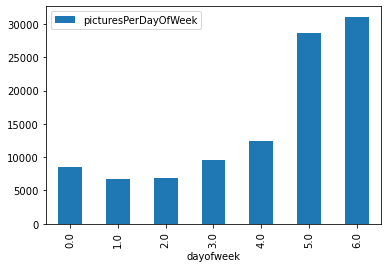

In [55]:
combine_all_data['dayofweek']=combine_all_data['Date'].dt.dayofweek
combine_all_data.groupby(['dayofweek']).agg(picturesPerDayOfWeek=('SourceFile','count')).plot(kind="bar")

In [56]:
df_no_home=combine_all_data[(combine_all_data['Place']!='Genf')& (combine_all_data['Place']!='Meyrin')
                            & (combine_all_data['Place']!='Lauchringen')
                            ].groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_no_home['DaysPerYearRatio']=df_no_home['DaysPerYear']/df_no_home['DaysInYear']
df_no_home.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
2006,13,0.035616
2007,15,0.041096
2008,35,0.095628
2009,46,0.126027
2010,43,0.117808
2011,33,0.090411
2012,47,0.128415
2013,55,0.150685
2014,56,0.153425


In [57]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
5530,/2009/090623 USA CTEQ09/090703 New York City/P...,NaT,NaN
18475,/2011/Lauchringen/P4240022-P420024 - Lauchring...,NaT,NaN
18514,"/2011/Private/PC310001 - Rust, Matthias im Eur...",NaT,NaN
53786,/2016/160910 Verbier & Hermence/P9110084 - Her...,NaT,NaN
53787,/2016/160910 Verbier & Hermence/P9110085 - Her...,NaT,NaN
53788,/2016/160910 Verbier & Hermence/P9110086 - Her...,NaT,NaN
53789,/2016/160910 Verbier & Hermence/P9110087 - Her...,NaT,NaN
53790,/2016/160910 Verbier & Hermence/P9110088 - Her...,NaT,NaN
53791,/2016/160910 Verbier & Hermence/P9110089 - Her...,NaT,NaN
53792,/2016/160910 Verbier & Hermence/P9110090 - Her...,NaT,NaN


<AxesSubplot:title={'center':'monthly count of  pictures'}, xlabel='Date', ylabel='picture count'>

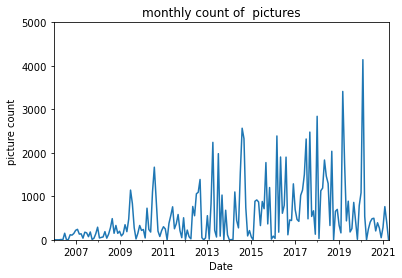

In [58]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'], utc=True)
#combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.groupby(pd.Grouper(key="Date", freq="M")).count()["SourceFile"].plot(title="monthly count of  pictures",ylabel="picture count",ylim=(0,5000))

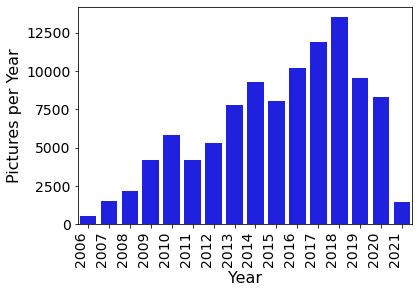

In [59]:
df_group=combine_all_data.groupby(pd.Grouper(key="Date", freq="Y")).count()["SourceFile"].reset_index()

ax = sns.barplot(x="Date", y="SourceFile", data=df_group,color = 'blue') 
x_dates = df_group['Date'].dt.strftime('%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Pictures per Year',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

In [60]:
combine_all_data.groupby([combine_all_data["Date"].dt.hour]).count()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,leapyear,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
0.0,351,339,351,351,337,351,351,343,351,343,...,281,267,267,275,277,267,351,343,351,351
1.0,509,499,509,509,480,509,509,500,509,500,...,449,426,426,429,446,426,509,509,509,509
2.0,595,588,595,595,580,595,595,588,595,588,...,538,529,529,529,535,529,595,595,595,595
3.0,599,589,599,599,588,599,599,590,599,590,...,509,502,502,503,508,502,599,598,599,599
4.0,430,425,430,430,425,430,430,425,430,425,...,409,409,409,409,405,409,430,427,430,430
5.0,459,453,459,459,450,459,459,453,459,453,...,386,382,382,382,386,382,459,459,459,459
6.0,1000,987,1000,1000,935,1000,1000,987,1000,987,...,909,870,854,856,899,854,1000,982,1000,1000
7.0,2031,1978,2031,2031,1702,2031,2031,1982,2031,1982,...,1898,1578,1560,1564,1875,1560,2031,2013,2031,2031
8.0,4636,4555,4636,4636,3904,4636,4636,4556,4636,4556,...,4409,3621,3604,3605,4382,3604,4636,4614,4636,4636


In [61]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.dayofyear)[['SourceFile','Aperture']].count().sort_values(by=['SourceFile'], ascending=False)
test_sth

,SourceFile,Aperture
Date,,
250.0,1437,1415
249.0,1396,1378
251.0,1390,1374
252.0,1070,1059
207.0,948,914
...,...,...
67.0,1,1
102.0,1,0
122.0,1,1


In [62]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.date).agg(photosPerDay=('SourceFile','count'),
                                                                        countries=('Country','unique'),
                                                                        places=('Place','unique'),
                                                                        weekday=('dayofweek','mean')
                                                                       ).sort_values(by=['photosPerDay'], ascending=False)
test_sth.head(20)

,photosPerDay,countries,places,weekday
Date,,,,
2020-02-26,769,[Italy],[Florenz],2.0
2020-02-28,610,"[Vatican, Italy]",[Rom],4.0
2017-09-07,548,"[Italy, Vatican]",[Rom],3.0
2020-02-29,535,"[Italy, Vatican]",[Rom],5.0
2013-04-04,501,"[Vatican, Italy]",[Rom],3.0
2017-09-08,495,"[Italy, Vatican]",[Rom],4.0
2019-03-17,484,[Italy],"[Ercolano, Portici, Neapel]",6.0
2020-02-25,443,[Italy],"[Siena, Colle di Val d'Elsa, San Gimignano]",1.0
2019-04-20,396,[France],"[Provins, Fontainebleau, Paris]",5.0


In [63]:
index_in=test_sth.index.values
range_in=list(range(1,367))

In [64]:
days_no_photos = set(index_in).symmetric_difference(set(range_in))
days_no_photos

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [65]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains("Dom|Duomo|Cathedral|Kathedrale|cathedral")])

10604

In [66]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(r'(?=.*Koeln)(?=.*Dom)',regex=True)])

187

In [67]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Versailles)(?=.*Schloss)',regex=True)])

990

In [68]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Potsdam)(?=.*Sanssouci)',regex=True)])

711

In [69]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Kathedrale)(?=.*Genf)',regex=True)])

398

In [70]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Chapelle)(?=.*Paris)',regex=True)])

205

In [71]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Notre)(?=.*Paris)',regex=True)])

184

In [72]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Borghese)(?=.*Rom)',regex=True)])

187

In [73]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Maria Maggiore)(?=.*Rom)',regex=True)])

181

In [74]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Peter)(?=.*Rom)',regex=True)])

435

In [75]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Sagrada)(?=.*Barcelona)',regex=True)])

224

In [76]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Paris)(?=.*Saint)',regex=True)])

333

In [77]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*om)(?=.*Mailand)',regex=True)])

435

In [78]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Siena)(?=(.*Duomo|.*Dom))',regex=True)])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


321

In [79]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Palast|Chateau|Castle|Palace|Schloss|Residenz|Palazzo|Palais|palast|Reggia|Castelo|Burg|burg|Villa|Eremitage|Belvedere")])

28649

In [80]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rathaus|Hotel de Ville")])

1247

In [81]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Oper|Opera|Theatre|Teatro|heater|Staatsoper")])

1290

In [82]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Grotta|Grottes|Cave|Grotte|hoehle|Hoehle")])

1596

In [83]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Unter&Grindelwald&gletscher")])

0

In [84]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Mer de Glace")])

291

In [85]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "See|Lac|Lake|Lago")])

2500

In [86]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Grenzgletscher|Gornergletscher")])

209

In [87]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Mont Blanc")])

296

In [88]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Matterhorn")])

288

In [89]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    "Lateran")) & (~combine_all_data["SourceFile"].str.contains(
    "palast"))& (~combine_all_data["SourceFile"].str.contains(
    "Schatzkammer"))])

203

In [90]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    r'(?=.*Rom)(?=.*Palazzo Quirinale)',regex=True)) | (combine_all_data["SourceFile"].str.contains("Quirinals"))])

207

In [91]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    r"(?=.*)(?=.*Jungfraufirn)",regex=True))]) 

223

In [92]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r"(?=.*)(?=.*Aareschlucht)",regex=True)])

189

In [93]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Berlin)(?=.*Reichstag)',regex=True)])

47

In [94]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gorge|Gorges|chlucht|Canyon|klamm")])

2184

In [95]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Neuschwanstein")])

101

In [96]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "fall|Falls|Cascade|foss|Ringquelle")])

1263

In [97]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "gletscher|Gletscher|Glacier|hiacciaio|Eismeer|firn|Plateau Rosa")])

5978

In [98]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Museo|Museum|museum|Uffizien|Museen|Eremitage|Louvre")])

4522

In [99]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    ", Aareschlucht")])

76

In [100]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Monet")])

70

In [101]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Goya")])

7

In [102]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Picasso")])

63

In [103]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rodin")])

32

In [104]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Dali")])

196

In [105]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Miro")])

32

In [106]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gogh")])

22

In [107]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Chagall")])

29

In [108]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Kandinsky")])

22

In [109]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Max Ernst")])

12

In [110]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Brueghel")])

27

In [111]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Canova")])

33

In [112]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Michelangelo")])

60

In [113]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Raffael")])

111

In [114]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "da Vinci")])

42

In [115]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rembrandt")])

32

In [116]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Giotto")])

11

In [117]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rubens")])

82

In [118]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Botticelli")])

14

In [119]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Lippi")])

7

In [120]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gauguin")])

10

In [121]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rothko")])

8

In [122]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Cezanne")])

17

In [123]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Giacometti")])

5

In [124]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Hodler")])

10

In [125]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Franz Marc")])

2

In [126]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Moschee|moschee/Cami")])

137

In [127]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "St Denis")])

115

In [128]:
#baroque
#Santa Maria Maggiore, Il Gesu, Sant'Ignazio, Theatinerkirche, Karlskirche, St Peter inside
#Santi Luca e Marina, Carlo alle Quattro Fontane, Andrea alla Quirinale, Louvre (Colonnade)
#Santa Maria della Salute, Sorbonne, Chateau de Maisons, Vaux-le-Vicomte, Palazzo Barberini, Versailles
#Louvre (part), Wuerzburg, Residenz Muenchen, Nymphenburg, Charlottenburg, Quirinale, Palazzo Pitti, 
#Passau, Salzburg, Caserta, Versailles, Naples, Schoenbrunn, Ludwigsburg, Mannheim, Rastatt
#Peter & Paul Krakow, Superga, Carignano, Madama, St Pauls, Greenwich Hospital, Blenheim Palace, Belvedere Vienna, 
#Clementinum Prague, Amalia Library, Santa Maria della Pace, Sapienza, Spanish Steps,Radcliffe Camera,
#Royal Palace Amsterdam, Palais Rohan, Poppelsdorf, Bonn, Benrath, Dresden (Innen)
#Hampton Court, Windsor Castle, Castle Howard, Chatsworth House, Castello del Valentino
#Lecce, Noto, Waldstein Palace, San Lorenzo Torino, Mafra Palace, Palazzo Reale Genua
#Aranjuez, Royal Palace Madrid, Schloss Eggenberg, Alte Residenz Salzburg, Het Loo Palace, Ksiaz Castle
#Torino, Venaria, Vaux-le-Vicomte, Winter Palace, Marinsky, Andre Kiev
#Puschkin, Peterhof, Peter & Paul Fortress, La Granja, Trevi Fountain, Cave Monastery Kiev
#Wilanow Palace, Zwinger, Frauenkirche, Pommersfelden, Goedoello, Fertoed
#Dome Invalides, Val de Grace, Drottningholm, Stockholm Palace, Fredensborg Palace, Amalienborg
#Tallin Catherinethal, Champs-sur-Marne

In [129]:
#gothic
#Westminster Abbey, "Westminster Hall","Old Hampton Court","old Eltham","old Hatfield","Stirling Castle","Conciergerie"
#Cathedral: Reims, Amiens, Orleans, Chartres, St Denis, Paris, Bourges, Strasbourg, Lyon
#Cathedral Canterbury, Chester, Glasgow, Edinburgh, Lincoln
#Duomo Milan, Siena, Hohensalzburg
#Dom Koeln, Frauenkirche, Regensburg, Stephansdom
#St Chapelle Paris, Vincennes, Christ Church College, King's College
#Scrovegni Chapel, Matthiaskirche, Kensington Palace
#Windsor Castle Church, Windsor Castle Church, Bath Abbey
#Prager Burg alt, Conciergerie, Vincennes
#Toledo, Segovia,Sevilla cathedrals, new cathedral Salamanca
#Maulbronn, Burgos Cathedral, Orvieto, St Maria sopra minerva
#Brussels Town Hall, La Llotja Valencia, Belfry Bruges
#Palais Papale, St Martin Landshut, Rouen, York Minster, Freiburg Minster, Ulm, Lorenz Nuernberg
#Brussels Cathedral, Antwerp Cathedral, Leuxen Town Hall, Mechelen Cathedral, Belfry Ghent, Albi Cathedral
#Palazzo Publico, Nieuwe Kerk Amsterdam, Wroclaw Town Hall, Mary Church, Krakow , Krakow Cathedral
#Faountains Abbey, Oranienbaum, Strelna, Palace of the Marquis of Dos Aguas, Skokloster, Dolmabahce
#Jeronimos Monastery, Leon, Avila, Valencia Cathedral, Bern Minster, Bodleian Library, St Mary Luebeck, Dom Schwerin, Luebeck

In [130]:
#classicism
#Wiesbaden, Chiswick House, Buckingham Palace, Capitol
#Petit Trianon, Chateau Bagatelle, Hotel de Salm, Compiegne, Academy Athens, Parliament Vienna, 
#Malmaison, Royal Palace Wroclaw, Menshikov, Stroganov
#Schloss Bellevue
#Isaac Cathedral, Pawlovsk, Gatchina, Somerset House, Budapest St Stephan, St Anna Warsaw, Prado,
#British Museum, Marmorpalais, Palaces on the Isle, Warsaw Royal Palace, Pantheon, Arc-et-Senans
#Palais Bourbon, Madelaine, Arc de Triomphe, 
#Galleria Borghese, Favorite Ludwigsburg, Wilhelmshoehe, Caserta, Capodimonte, 
#Kathedrale, Schlosskirche Kopenhagen,St Blasien
#Woerlitz, St Martin in the Fields, British Museum, Museumsinsel, Charlottenhof, Glienicke
#Glyptothek, Propylaeen, Koenigsbau Innen
#Brussels Royal Palace, Eisenstadt, Assisi Basilica, Santa Croce Florence, Palazzo Pitti (old quarters)

In [131]:
#romanesque
#Cathedral Rochester, Ely, Peterborough, Durham, Pisa, Worms, Mainz, Bamberg, Speyer, Limburg
#old Salamanca
#Hildesheim Michael, Cluny, Cloister Laterano, Cefalu, Palermo, Monreale
#Fontenay, St Savin
#Santa Maria in Cosmedin, Bitonton, Tower of London, Santiago de Compostela, Mt St Michel, Battistero Firenze, Cremona, Laterano
#Mt Saint-Michel, Vezelay, La Seu Lisbon, old Cathedral Coimbra, St Sernin, San Isidro Leon, Reichenau
#Arles, Trogir, Basel, Anagni crypt, Aquileia crypt, Bitonto, Molfetta, Trani, Bari Dom & Cathedral
#Castel del Monte, Wartburg, Rochester Castle, Canterbury Castle, Palazzo della Ragione Padua, Mantua, Genua
#Bayeux

In [132]:
#renaissance
#Hatfield House, Michaelskirche, Hofkirche Innsbruck, Palazzo Farnese, Sistine Chapel
#Blois, Chambord, Chenonceau, Fontainebleau, Louvre (Hof), Place des Voges, Amboise
#Palazzo Vecchio, Palazzo Ducale, Palazzo Te (Mantua), Palazzo Ducale (Venice), Laurentian Library Florence
#Hotel d'Assezat, St Eustache, St-Etienne-du-Mont, Certosa di Pavia, Scuola Grande di San Rocco
#Landshut Residenz, City Hall Bremen, Heidelberg, Rathaus Augsburg, Johannisburg Aschaffenburg
#Residenz Hof, City Hall Antwerp, Palazzo Schifanoia, Scuola Grande di San Marco
#University Salamanca, San Marco Leon, Charles V Alhambra, El Escorial, Granada Cathedral
#Villa Farnesina, Stanze Raffaele, Tempietto, Teatro Olympico, Villa Rotonda, Queen's House
#San Spirito, San Lorenzo, Palazzo Strozzi, Palazzo Medici Riccardi, Santa Maira Novella, Palazzo Rucellai
#Palazzo Ducale Urbino, Palazzo dei Diamanti, Santa Maria della Grazie, Prague Belvedere
#Banqueting Hall, Wawel Castle, Tomar Cloister, Belem Tower, Sao Roque, Frederiskborg, Pienza, Santa Maria degli Angeli Rome
#Kronborg, Rosenborg, Colleoni Chapel, Pazzi Chapel, Santa Maria della Pace, Ca d'Oro
#Biblioteca Marciana Venice, Basilica Palladiana (Vicenza), Cloth Hall Krakow, Concento San Esteban
#Gripsholm

In [133]:
#neobaroque

In [134]:
#neogothic
#"Votivkirche","Washington, National Cathedral", "NYC, St Patrick's Cathedral", "NYC, St John's Divine","Liverpool, Cathdral"
#Parlament London, Budapest, Strawberry Hill, Guildhall London

In [135]:
#rokoko
#Amalienburg, Sanssouci
#Wieskirche, Vierzehnheiligen
#Hotel Soubise, Hotel de Lassay, Hotel Matignon, Hotel de la Marine
#Ca Rezzonico, Wuerzburg Residenz, Solitude, Cuvilies, Augustusburg, Schaezlerpalais
#Queluz, Neues Schloss & eremitage Bayreuth, Bayreuth Theater
#Melk, Stupigini, Doria-Pamphilj, Katharinenschloss
#Bruchsal,Asamkirche, Seehof

In [136]:
#neoromanesque

In [137]:
#neorenaissance

In [138]:
#neobyzantine
#"Westminster Cathedral"